In [1234]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1235]:
data_dir = r"C:\Users\Adam\Data\Lisa\platelets\Platelet data 2018-05-12"

quickly define two helper functions - find_files, to find files recursively within a directory & subdirectories, and csv_list_to_dataframe, which loads dataframes and returns a concatenated output

In [1236]:
def find_files( data_dir, pattern ):
    """
    helper function to find files within a directory structure
    arguments: 
        string data_dir: path to directory to be searched (including subdirs)
        string pattern: string to find in filenames
        
    returns:
        list results: list of string paths to files with names containing string 'pattern'
    """
    results = []
    for root, dirs, files in os.walk(data_dir):
        for file in files: # loops through directories and files
            if pattern in file: # compares to your specified conditions
                results.append( os.path.join(root,file))
    return results

def csv_list_to_dataframe( csv_list ):
    """
    helper function to load and concatenate dataframes
    arguments: 
        list csv_list: list of path+filename strings to be loaded
        
    returns:
        dataframe : concatenated results
    """
    df_list = []
    for file in csv_list:
        df =  pd.read_csv(file)
        df['Source'] = file
        df.columns = [c.lstrip('0123456789_').strip('_') for c in df.columns]
        for c in df.columns:
            if '.1' in c:
                print(file)
                print(c)
            if c[-1] =='_':
                print(file)
                print(c)
        df_list.append( df )
    return pd.concat( df_list )
        

In [1245]:
# find and load data
file_list = find_files(data_dir, '.csv')
df = csv_list_to_dataframe( file_list )

# Extract some misc info from the filename
df['Replicate Number'] = df['Source'].str.extract(r"Rep ([0-9])", expand = False).astype(int)

df['Fraction'] = df['Source'].str.extract(r"(supe|pellet)", expand = False)
df['Mode'] = df['Source'].str.extract(r"(pos|neg)", expand = False)
df['Treatment'] = df['Source'].str.extract(r"(activated|blank|hsd1|hsd2)", expand = False)

In [1246]:
# dump un-needed columns, specifically 'dilution', 'repeat' and 'NEW'.  I don't know what they are
df = df[ [c for c in df.columns if ( ('dil' not in c) & ('repeat' not in c) & ('NEW' not in c) )]]

In [1247]:
#df = df.drop_duplicates(subset=['Source','compound'], keep = 'first')

In [1251]:
for c in df.columns:
    print(c)

Source
activated_pellet_a_neg
activated_pellet_a_pos
activated_pellet_b_neg
activated_pellet_b_pos
activated_supe_a_neg
activated_supe_a_pos
activated_supe_b_neg
activated_supe_b_pos
blank_mid_a_neg
blank_mid_a_pos
blank_mid_b_neg
blank_mid_b_pos
blank_post_a_neg
blank_post_a_pos
blank_post_b_neg
blank_post_b_pos
blank_pre_a_neg
blank_pre_a_pos
blank_pre_b_neg
blank_pre_b_pos
blank_pre_c_neg
blank_pre_c_pos
buffer_pellet_a_neg
buffer_pellet_a_pos
buffer_pellet_b_neg
buffer_pellet_b_pos
buffer_supe_a_neg
buffer_supe_a_pos
buffer_supe_b_neg
buffer_supe_b_pos
compound
compoundId
expectedRtDiff
goodPeakCount
groupId
hsd1_pellet_a_neg
hsd1_pellet_a_pos
hsd1_pellet_b_neg
hsd1_pellet_b_pos
hsd1_supe_a_neg
hsd1_supe_a_pos
hsd1_supe_b_neg
hsd1_supe_b_pos
hsd2_pellet_a_neg
hsd2_pellet_a_pos
hsd2_pellet_b_neg
hsd2_pellet_b_pos
hsd2_supe_a_neg
hsd2_supe_a_pos
hsd2_supe_b_neg
hsd2_supe_b_pos
label
maxQuality
medMz
medRt
metaGroupId
non_pellet_a_neg
non_pellet_a_pos
non_pellet_b_neg
non_pellet_b_pos

In [1139]:
# a quick check to see how many compounds show up in all replicates
df.groupby(['compound']).apply(lambda x: len(x['Replicate Number'].unique())).value_counts()

1    250
2    154
3     66
dtype: int64

c:\users\adam\anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


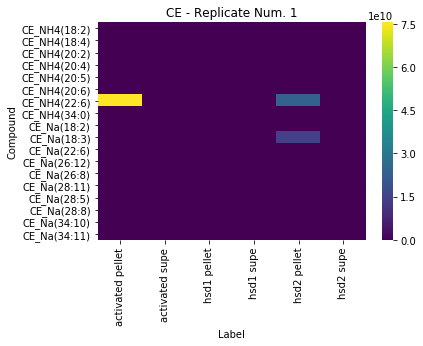

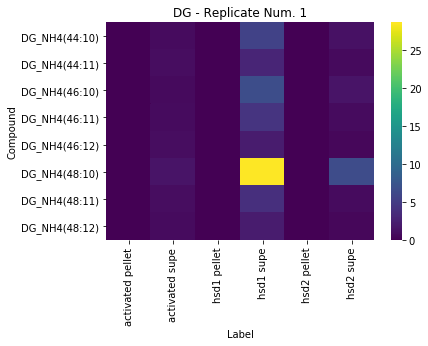

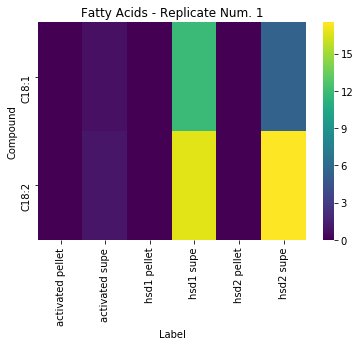

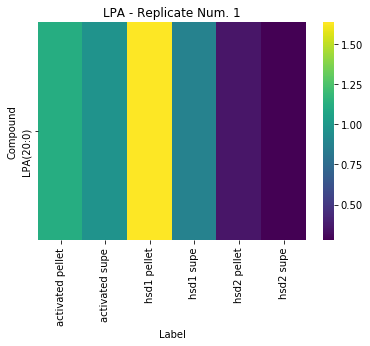

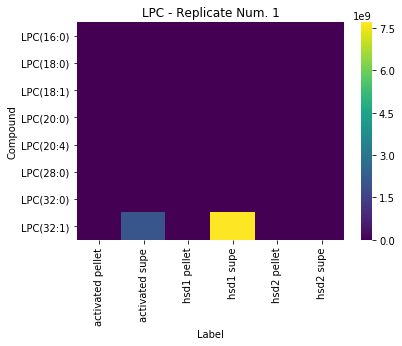

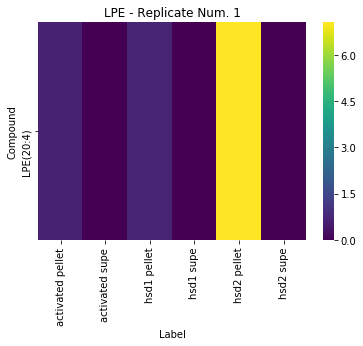

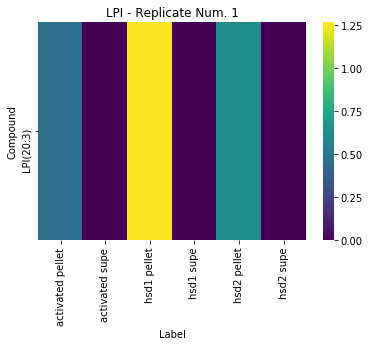

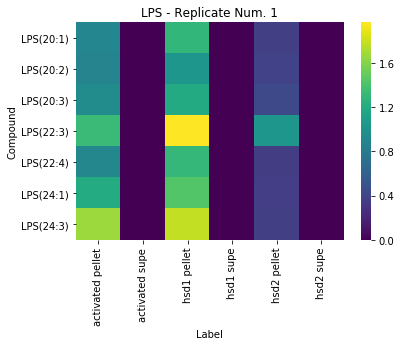

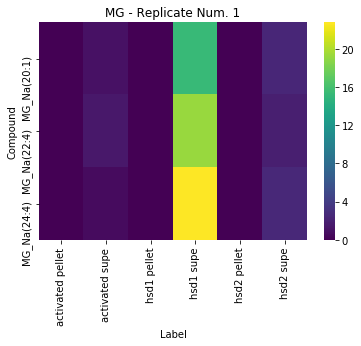

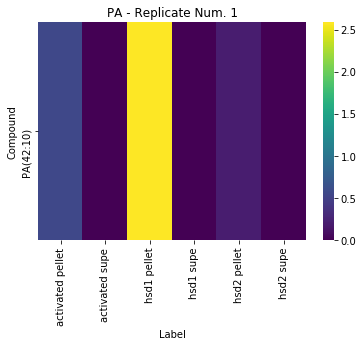

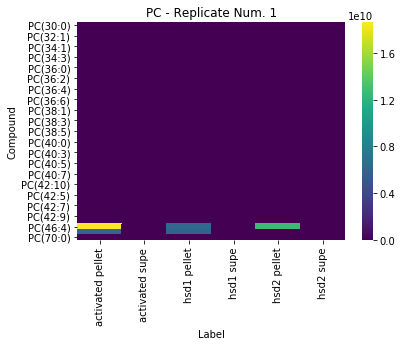

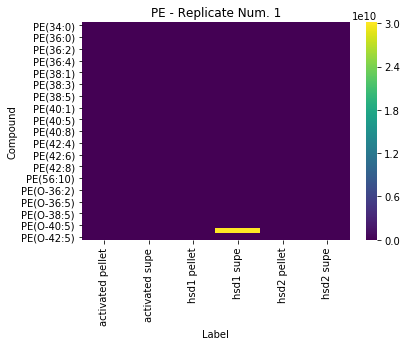

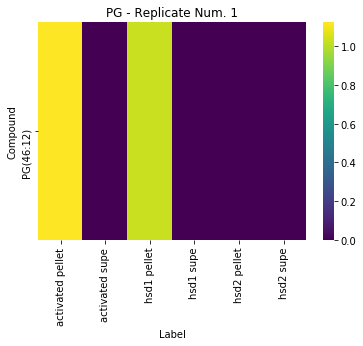

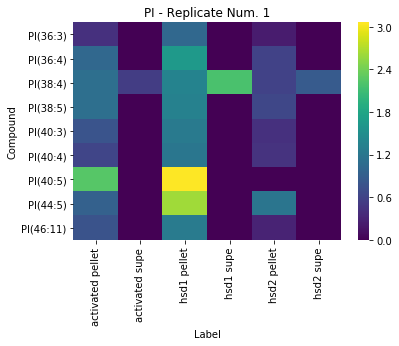

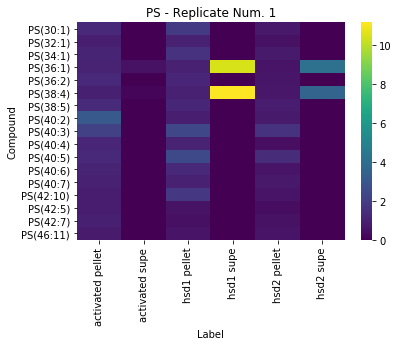

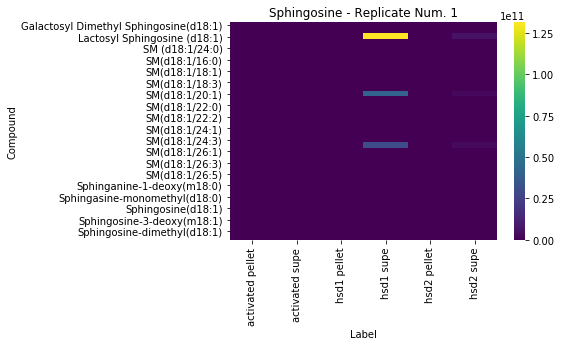

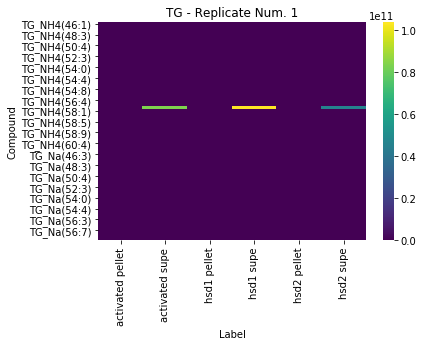

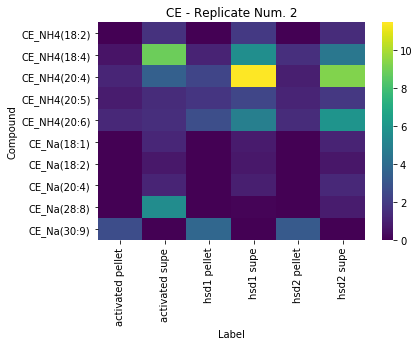

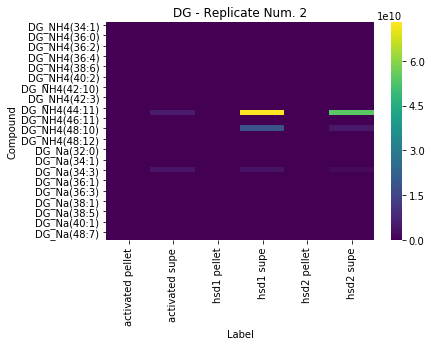

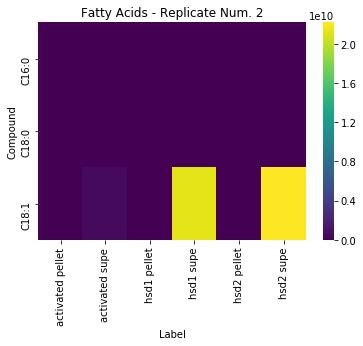

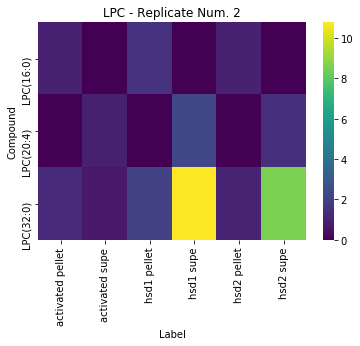

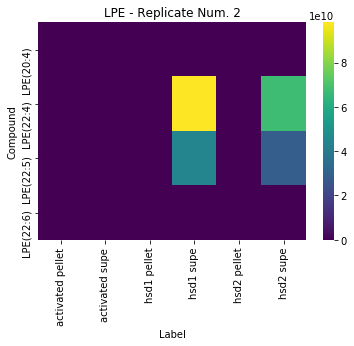

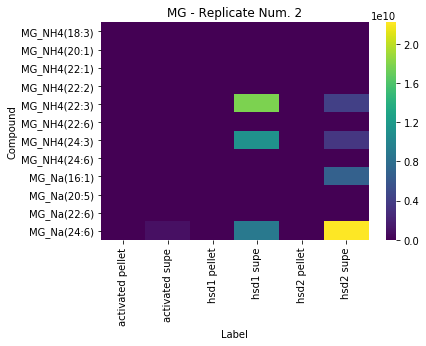

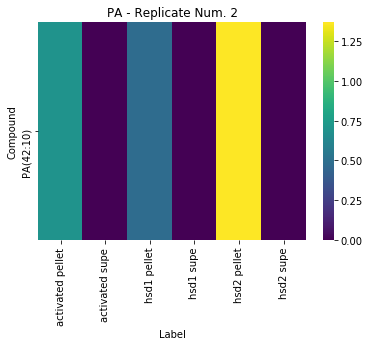

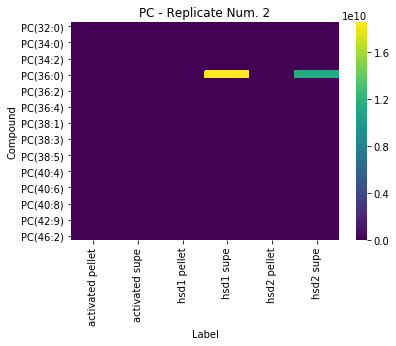

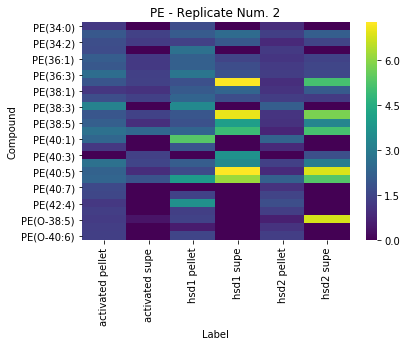

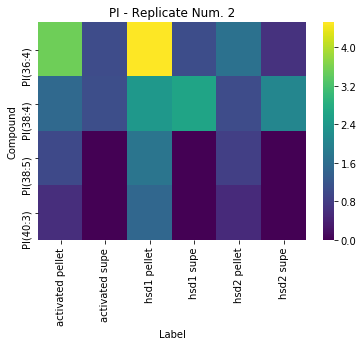

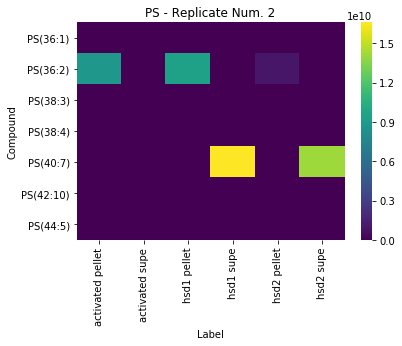

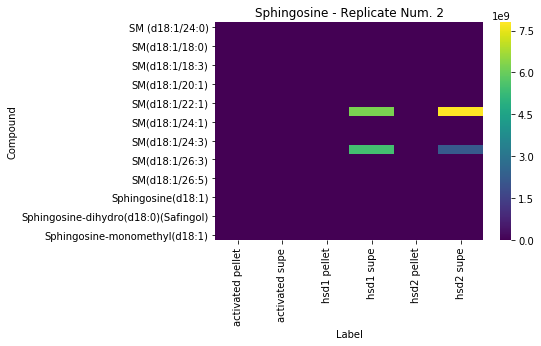

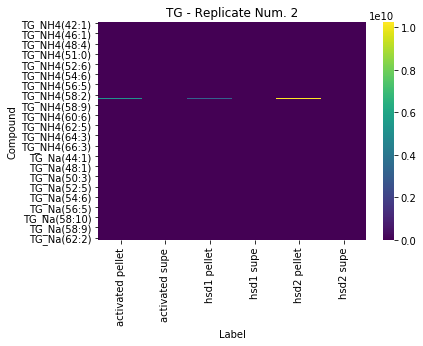

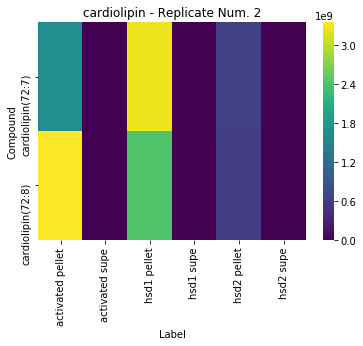

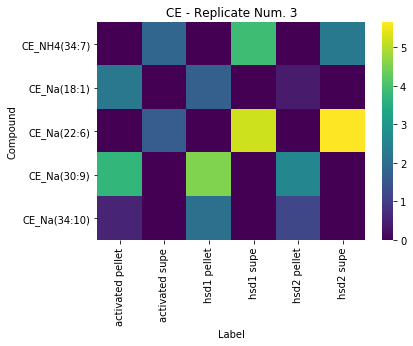

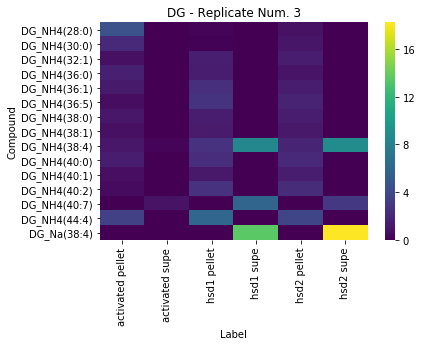

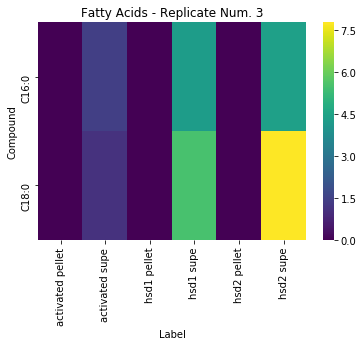

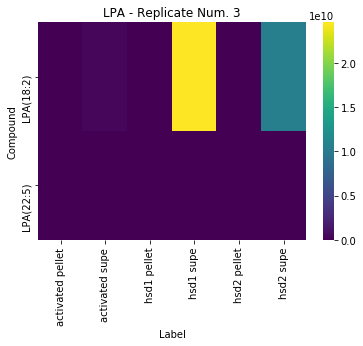

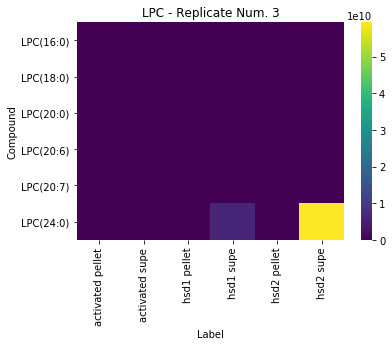

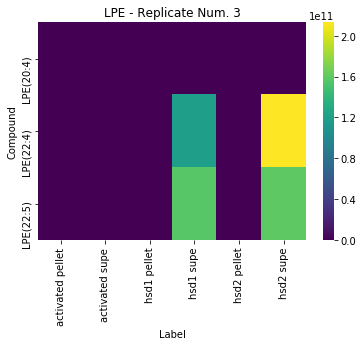

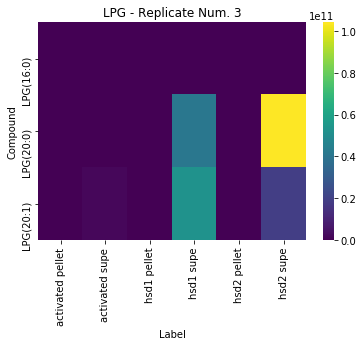

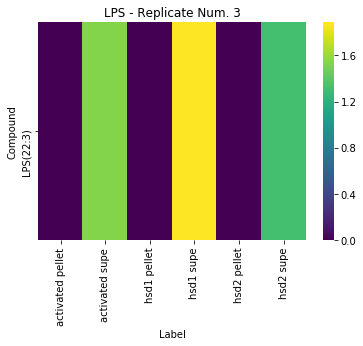

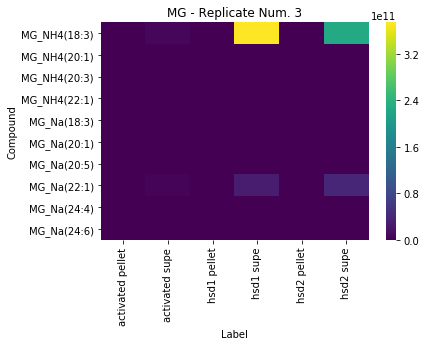

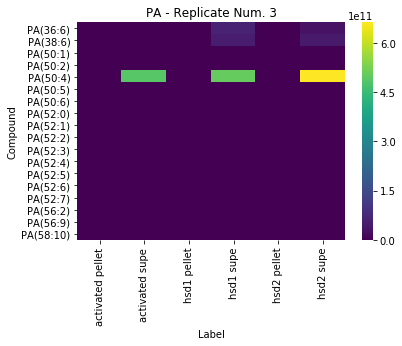

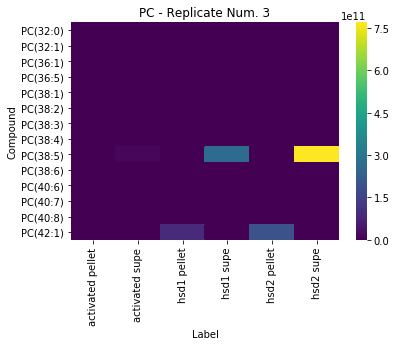

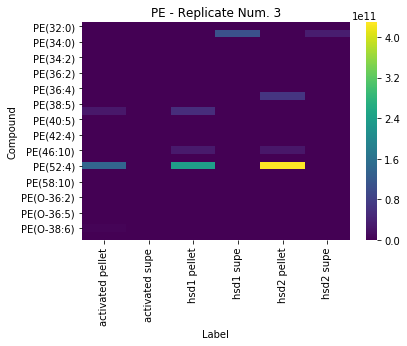

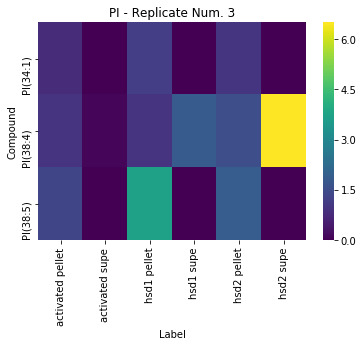

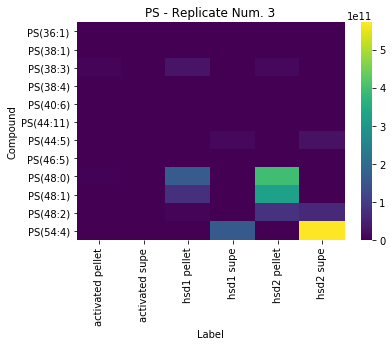

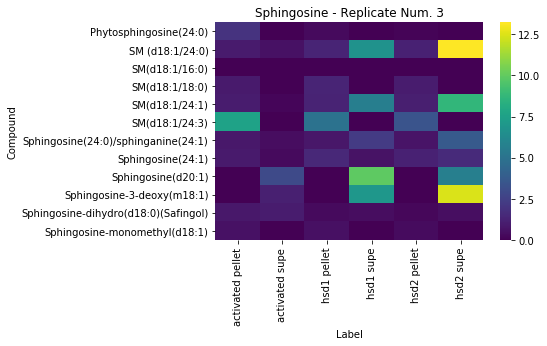

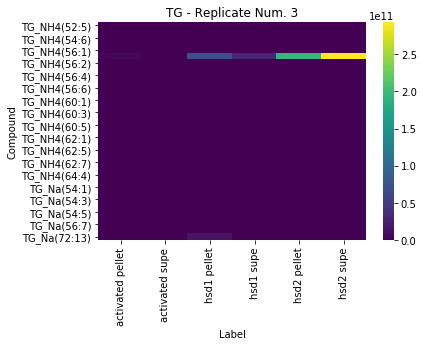

In [1184]:
for rep_num in [1,2,3]:
    results = []

    for lbl, grp in df[ (df['Replicate Number'] == rep_num)  ].groupby(['compound']):

        data = grp[ [c for c in grp.columns if '_' in c] ].T.copy().fillna(0).max(axis=1)
        data = data.reset_index()

        data['Fraction'] = data['index'].str.extract(r"(supe|pellet|blank)", expand = False)
        data['Mode'] = data['index'].str.extract(r"(pos|neg)", expand = False)
        data['Treatment'] = data['index'].str.extract(r"(activated|blank|hsd1|hsd2|non|buffer)", expand = False)
        data['Subsample'] = data['index'].str.extract(r"_([ab])_", expand = False)

        for index,row in data.fillna(0).iterrows():

            if row['Treatment'] in ['non','blank','buffer']:
                continue

            ref = data[ (data['Fraction'] == row['Fraction']) & 
                       (data['Treatment'] == 'non') &
                      (data['Mode'] == row['Mode']) &
                      (data['Subsample'] == row['Subsample'])][data.columns[1]].fillna(0).iloc[0]

            f = row[data.columns[1]] / (ref + 0.000001 )

            # figure out the head group
            if ':' in lbl.split('(')[0]:
                head_group = 'Fatty Acids'
            elif ( ('sphing' in lbl.lower()) or ('SM' in lbl) ):
                head_group = 'Sphingosine'
            else:
                head_group = lbl.split('(')[0].split('_')[0]

            results.append({'Compound' : lbl,
                            'Index' : index,
                            'Ref' : ref,
                            'Fold Change' : f,
                            'Label' : row['Treatment'] + ' ' + row['Fraction'],
                            'Sample' : row['index'][-5],
                            'Fraction' : row['Fraction'],
                           'Mode': row['Mode'],
                            'Head Group': head_group,
                            'Signal' : row[data.columns[1]],
                           'Treatment': row['Treatment']})

    results = pd.DataFrame(results)

    for lbl, grp in results.groupby('Head Group'):

        plt.figure()
        plt.grid(color = 'white')

        d = grp.groupby(['Compound','Label','Sample'])['Fold Change'].max().reset_index()\
        .groupby(['Compound','Label'])['Fold Change'].mean().reset_index()

        sns.heatmap( d.pivot( index = 'Compound', values = 'Fold Change', columns = 'Label'), cmap = 'viridis' )
        plt.title("{} - Replicate Num. {}".format(lbl, rep_num) )
        
plt.show()

In [1185]:
grp = df[ (df['Replicate Number']==1) & (df['compound']=='PE(36:1)')]
data = grp[ [c for c in grp.columns if '_' in c] ].T.copy().fillna(0).max(axis=1)
data = data.reset_index()
data

index           0
0   activated_pellet_a_neg       0.000
1   activated_pellet_a_pos  402962.800
2   activated_pellet_b_neg       0.000
3   activated_pellet_b_pos  381102.600
4     activated_supe_a_neg       0.000
5     activated_supe_a_pos       0.000
6     activated_supe_b_neg       0.000
7     activated_supe_b_pos       0.000
8          blank_mid_a_neg       0.000
9          blank_mid_a_pos   12642.040
10         blank_mid_b_neg       0.000
11         blank_mid_b_pos    8567.694
12        blank_post_a_neg       0.000
13        blank_post_a_pos       0.000
14        blank_post_b_neg       0.000
15        blank_post_b_pos       0.000
16         blank_pre_a_neg       0.000
17         blank_pre_a_pos   13826.200
18         blank_pre_b_neg       0.000
19         blank_pre_b_pos   11685.090
20         blank_pre_c_neg       0.000
21         blank_pre_c_pos    9263.826
22     buffer_pellet_a_neg       0.000
23     buffer_pellet_a_pos   10061.020
24     buffer_pellet_b_neg       0.000
25     buffer_pellet_b_pos       0.000
26       buffer_supe_a_neg       0.000
27       buffer_supe_a_pos       0.000
28       buffer_supe_b_neg       0.000
29       buffer_supe_b_pos       0.000
30       hsd1_pellet_a_neg       0.000
31       hsd1_pellet_a_pos  433751.800
32       hsd1_pellet_b_neg       0.000
33       hsd1_pellet_b_pos  436286.200
34         hsd1_supe_a_neg       0.000
35         hsd1_supe_a_pos       0.000
36         hsd1_supe_b_neg       0.000
37         hsd1_supe_b_pos       0.000
38       hsd2_pellet_a_neg       0.000
39       hsd2_pellet_a_pos  243395.400
40       hsd2_pellet_b_neg       0.000
41       hsd2_pellet_b_pos   26544.960
42         hsd2_supe_a_neg       0.000
43         hsd2_supe_a_pos       0.000
44         hsd2_supe_b_neg       0.000
45         hsd2_supe_b_pos       0.000
46        non_pellet_a_neg       0.000
47        non_pellet_a_pos  359387.300
48        non_pellet_b_neg       0.000
49        non_pellet_b_pos  375043.400
50          non_supe_a_neg       0.000
51          non_supe_a_pos       0.000
52          non_supe_b_neg       0.000
53          non_supe_b_pos       0.000

c:\users\adam\anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


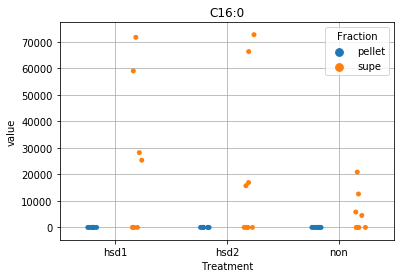

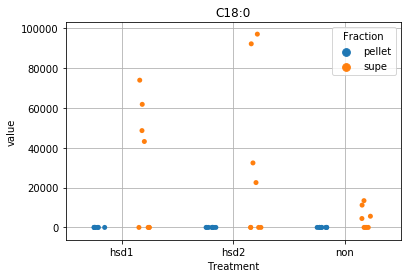

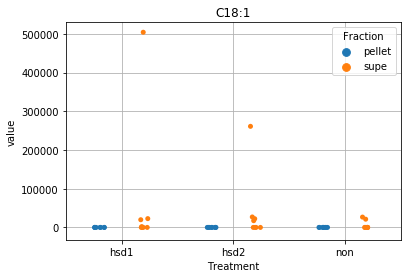

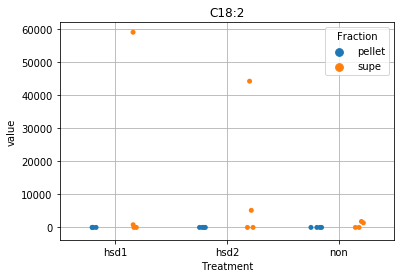

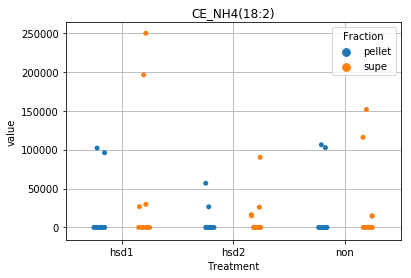

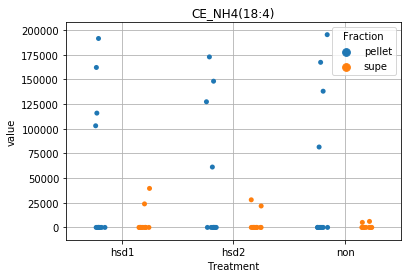

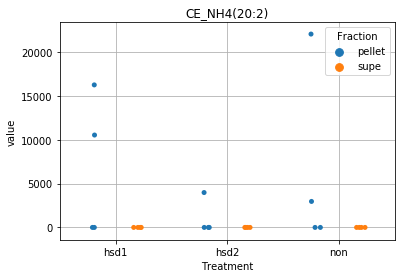

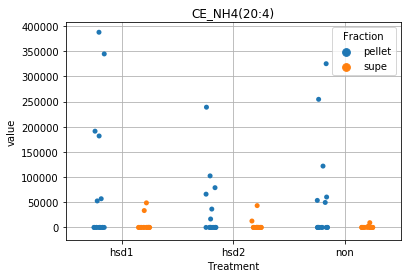

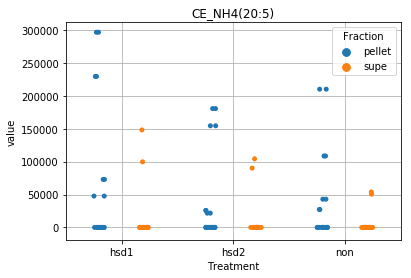

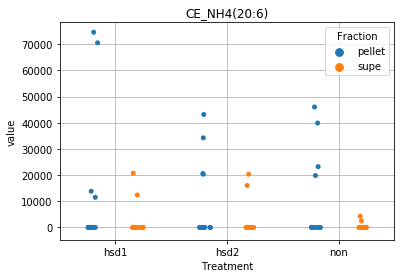

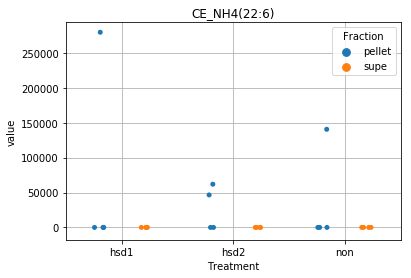

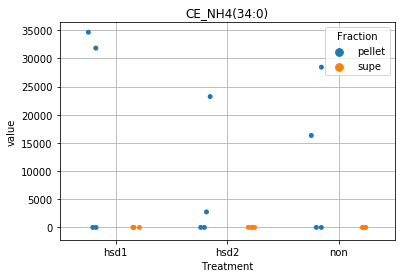

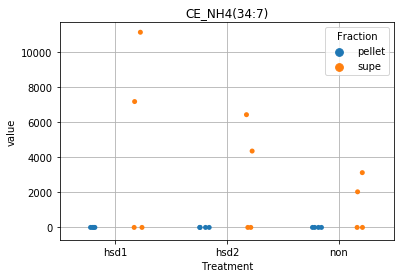

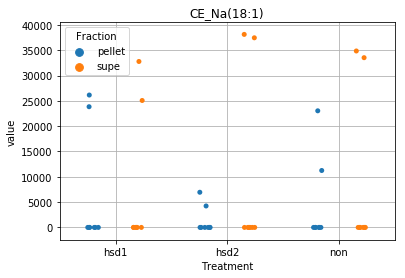

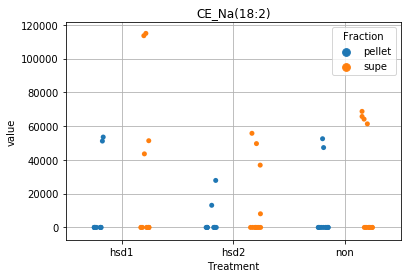

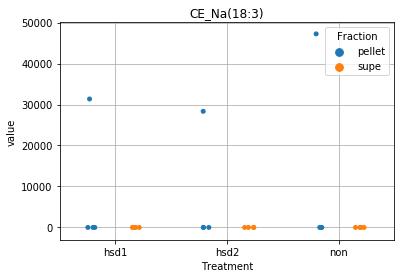

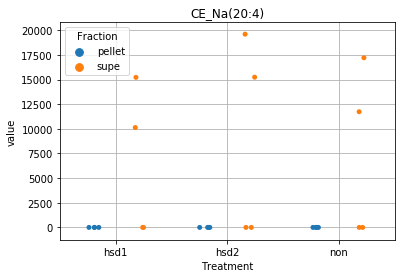

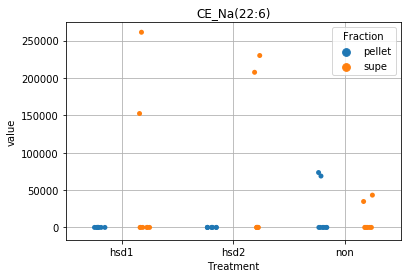

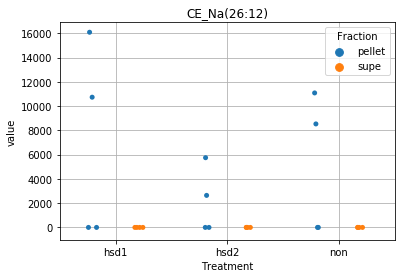

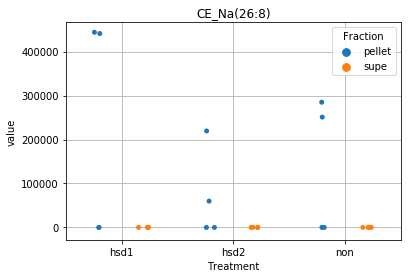

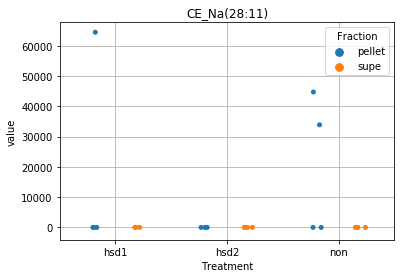

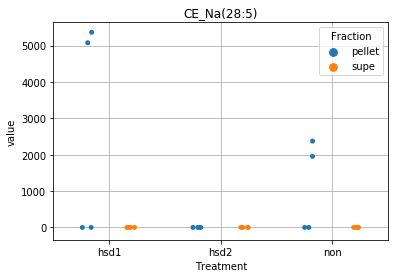

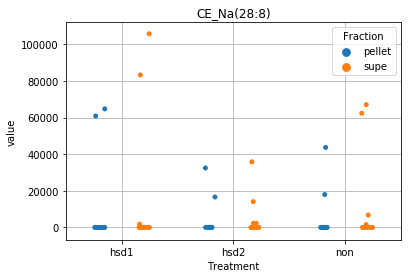

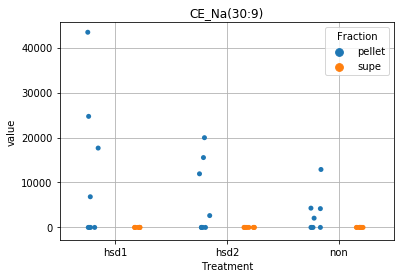

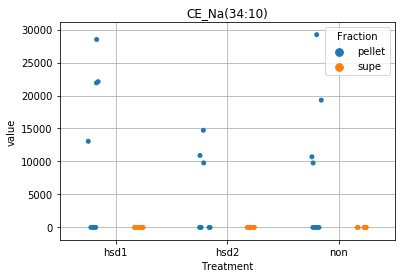

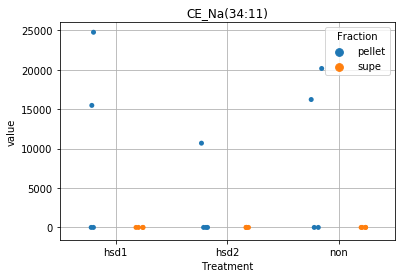

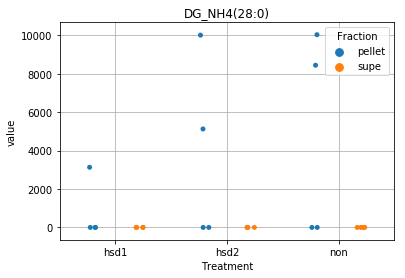

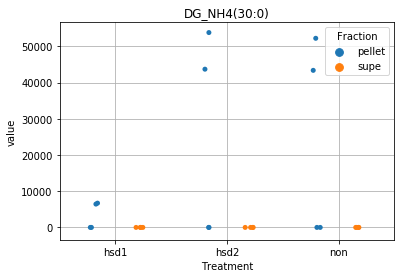

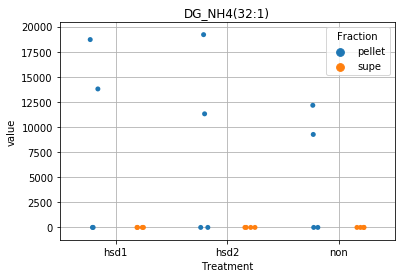

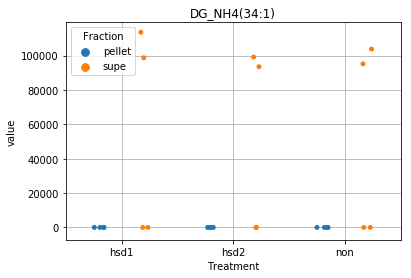

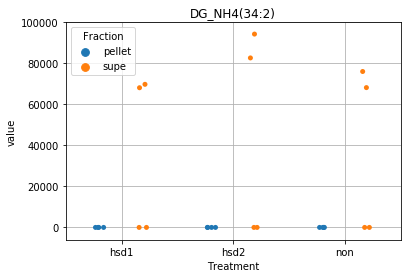

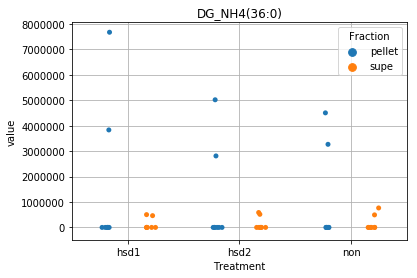

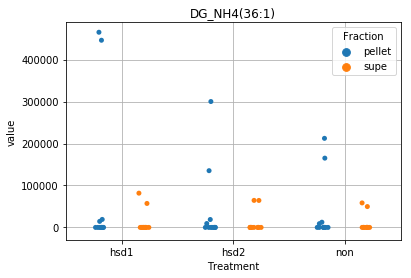

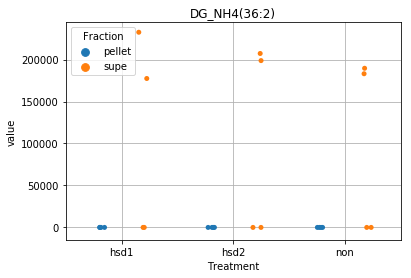

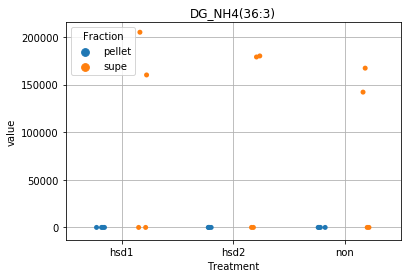

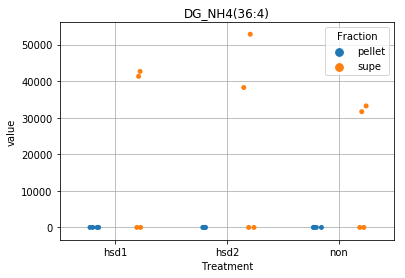

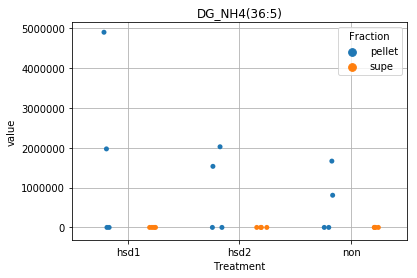

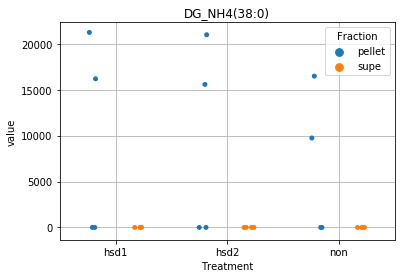

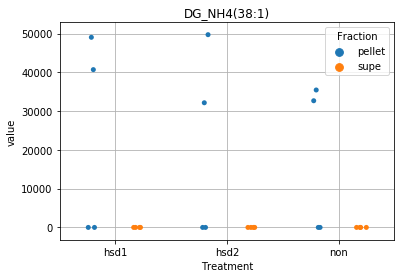

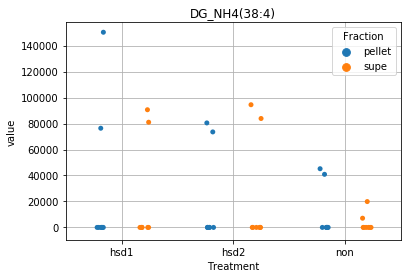

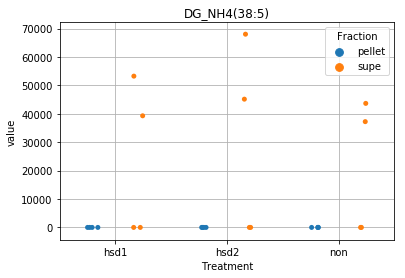

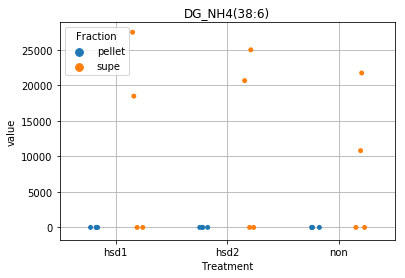

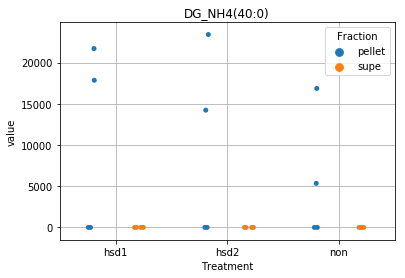

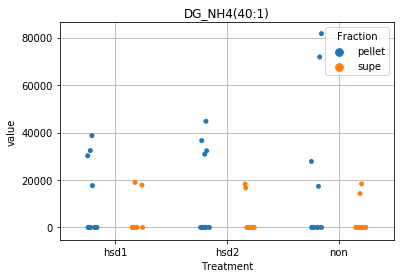

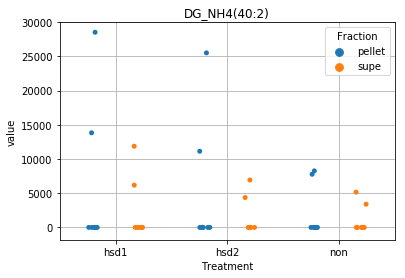

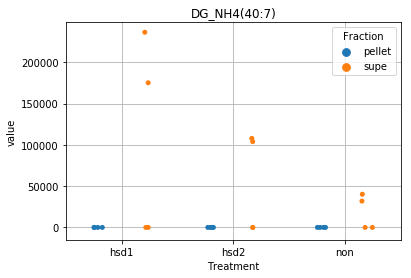

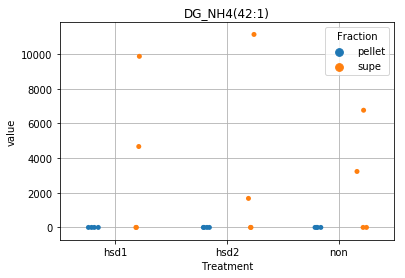

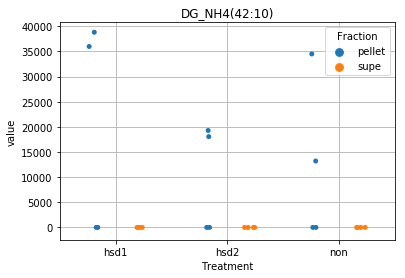

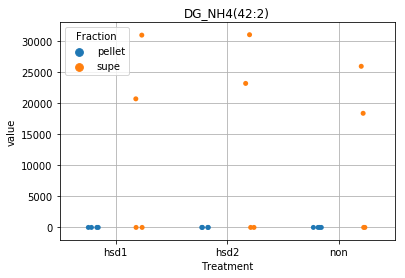

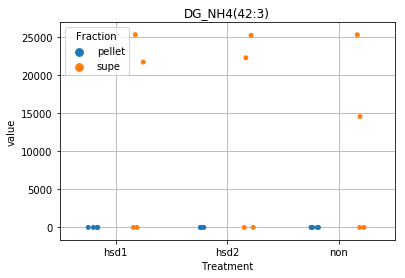

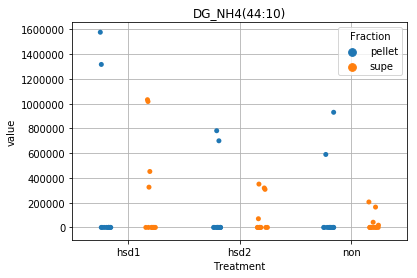

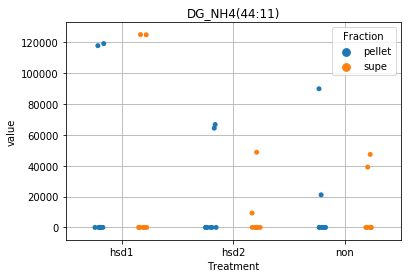

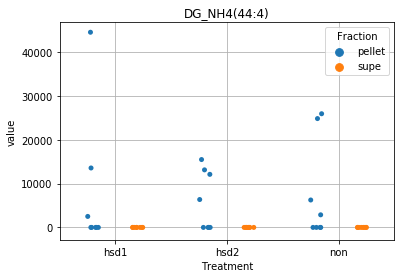

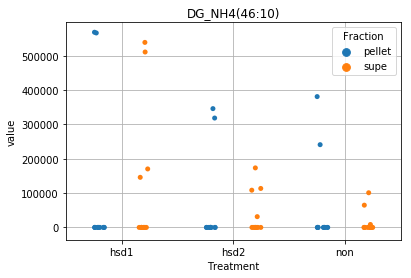

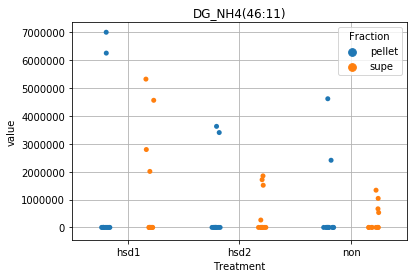

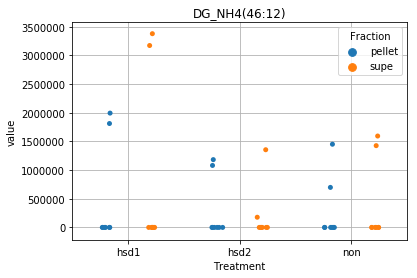

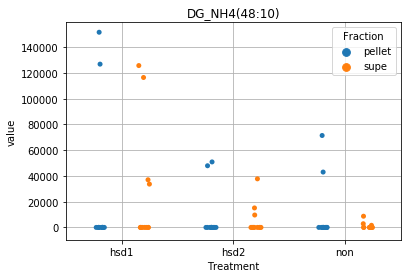

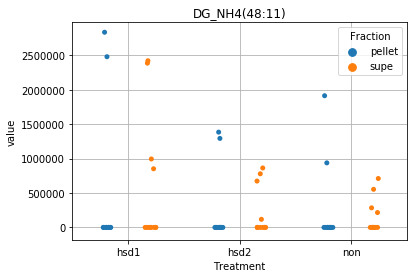

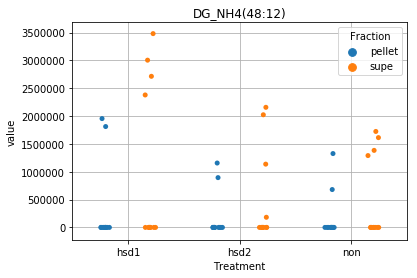

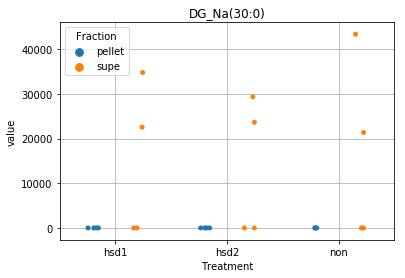

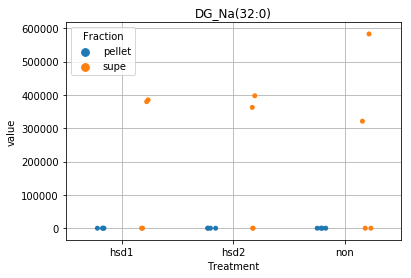

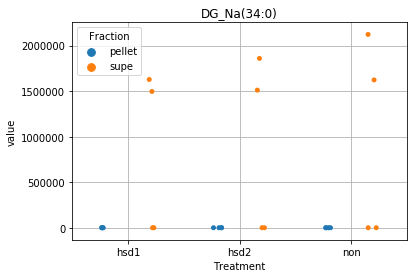

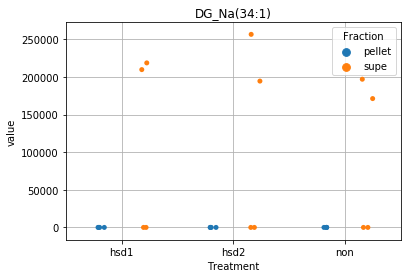

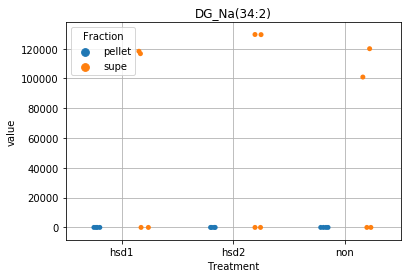

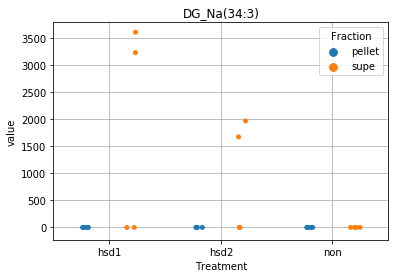

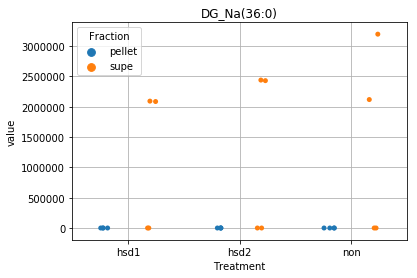

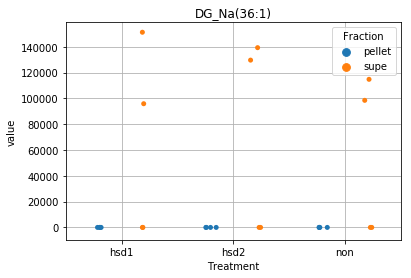

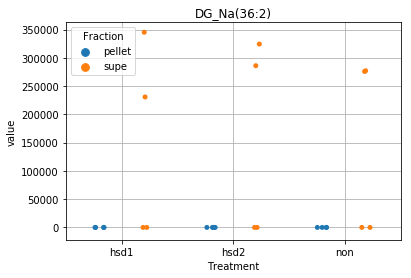

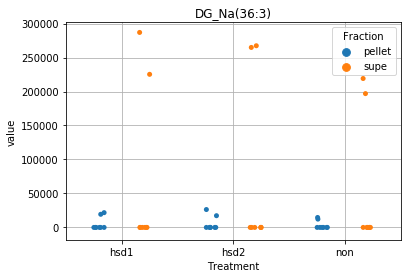

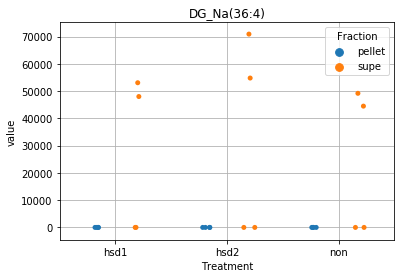

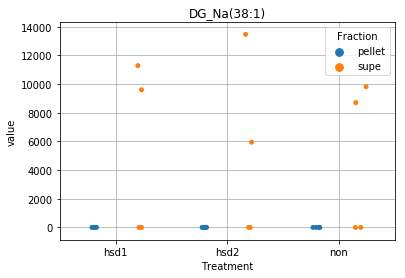

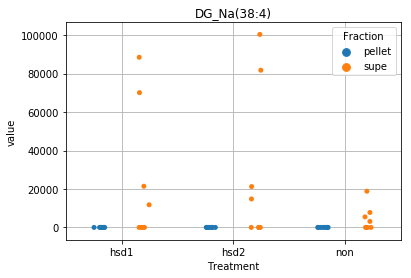

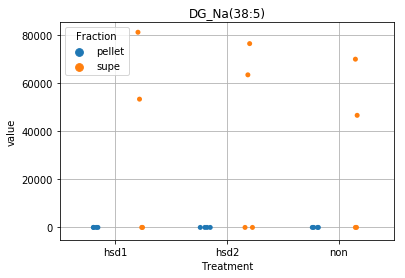

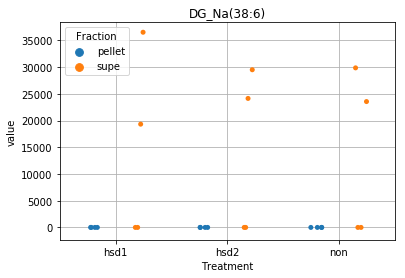

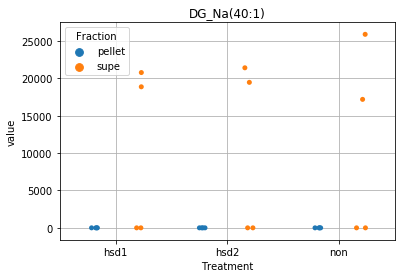

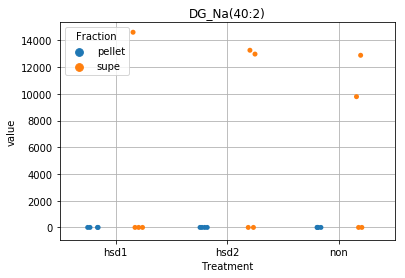

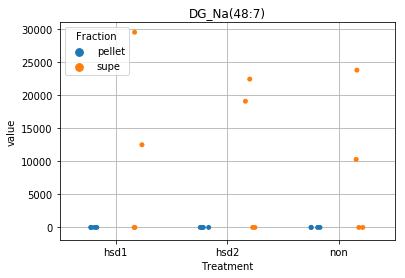

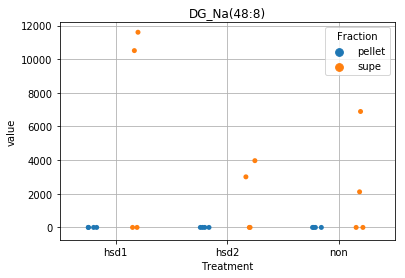

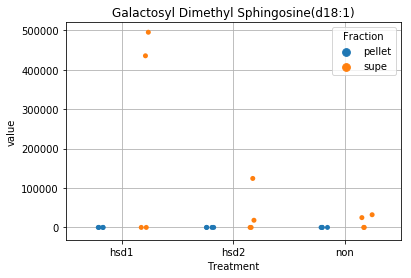

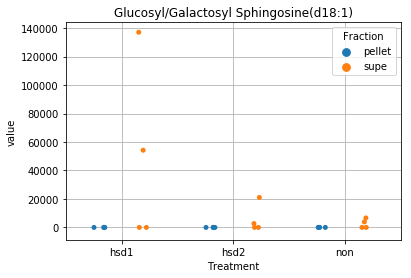

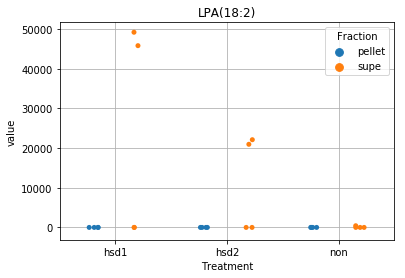

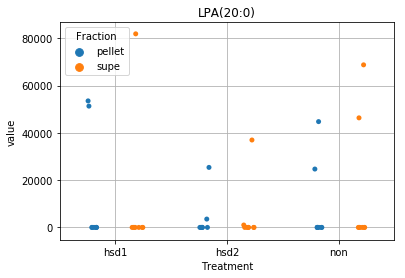

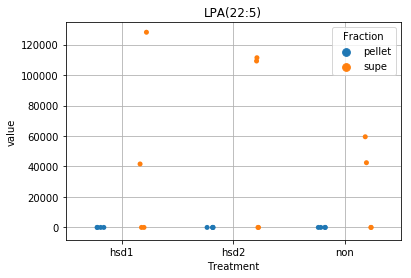

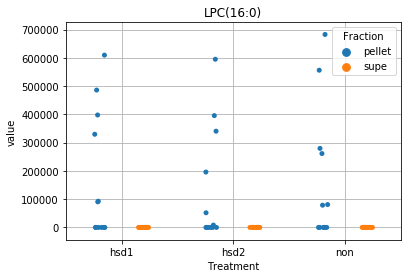

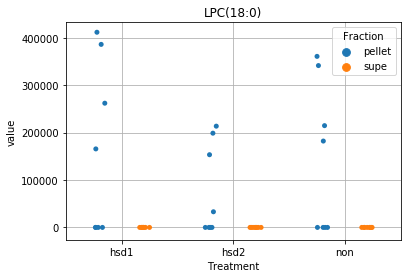

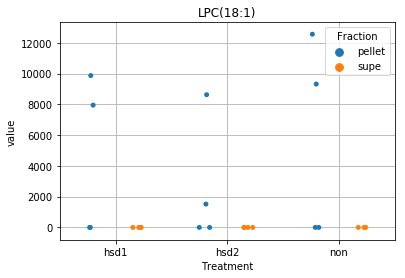

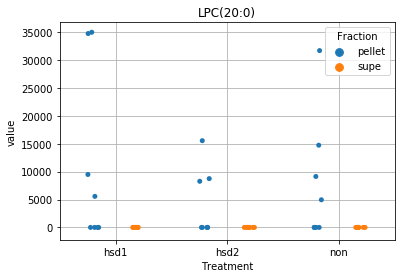

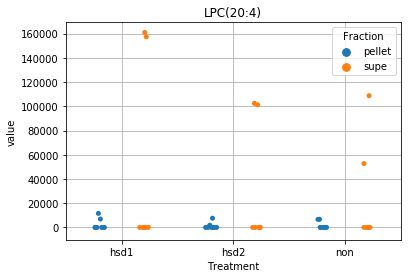

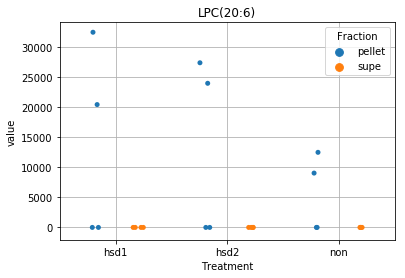

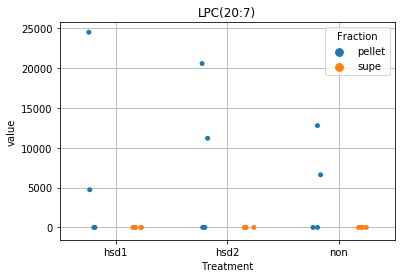

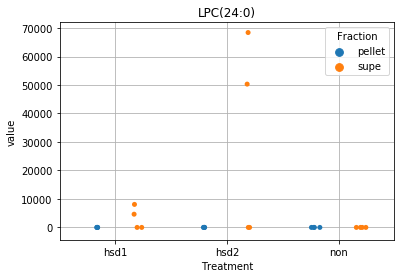

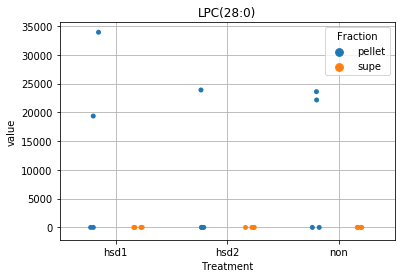

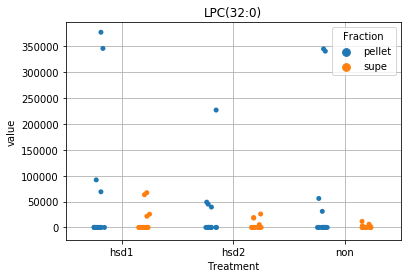

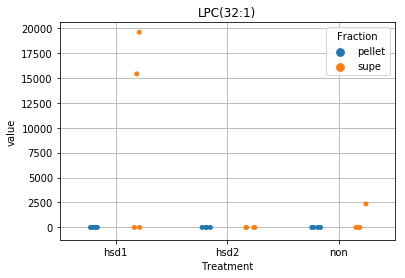

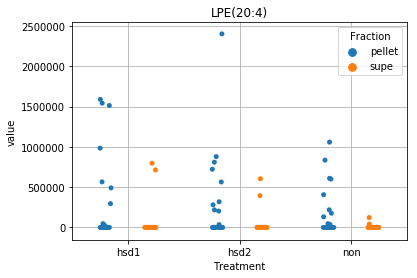

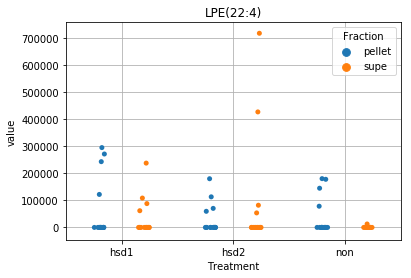

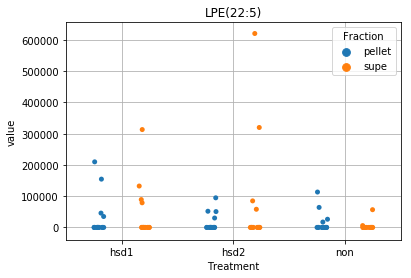

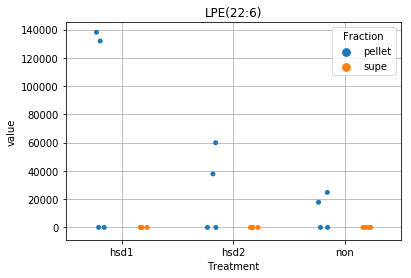

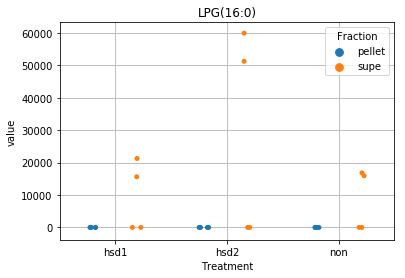

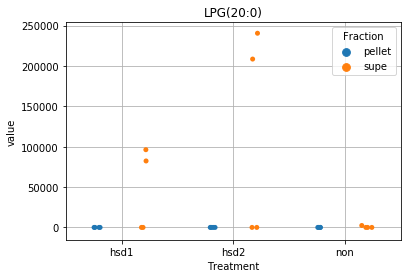

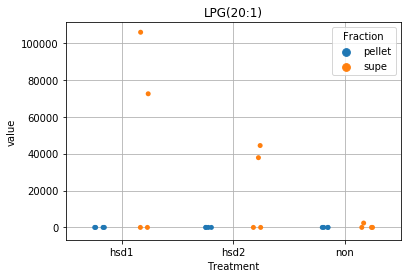

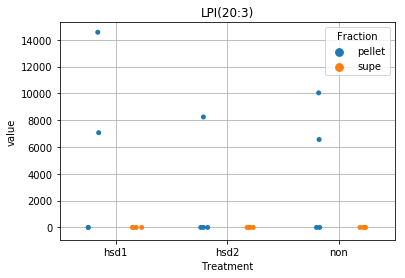

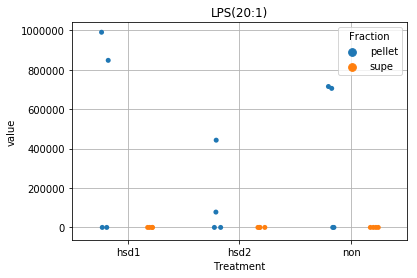

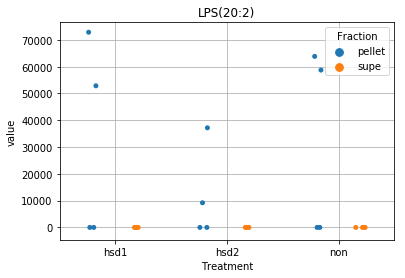

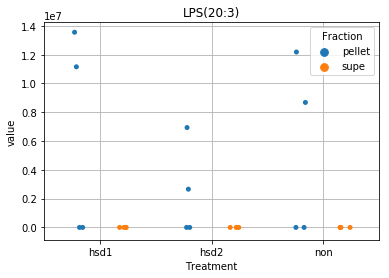

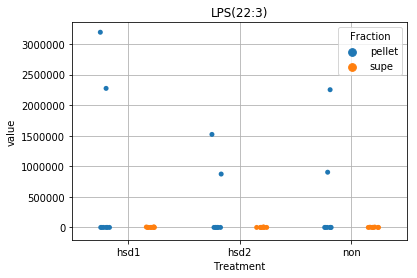

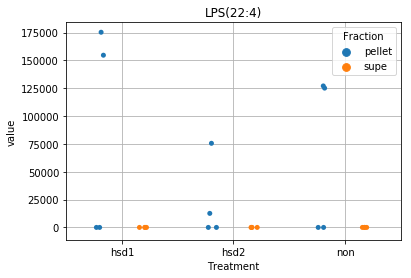

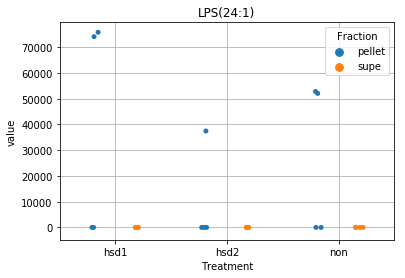

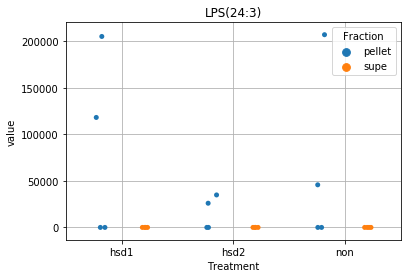

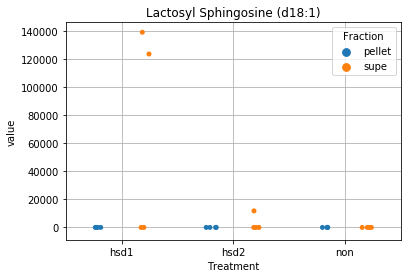

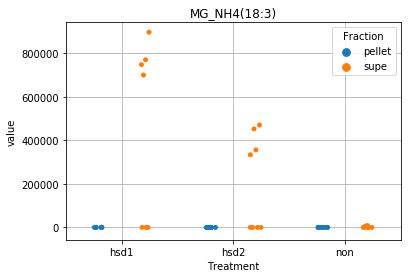

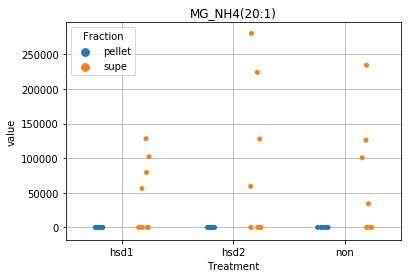

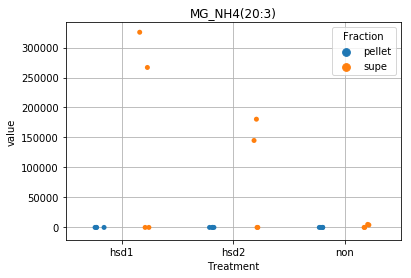

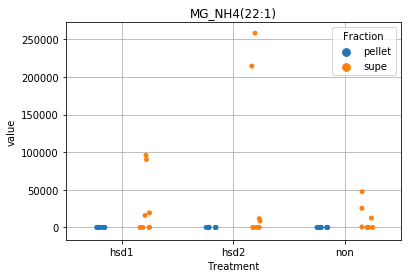

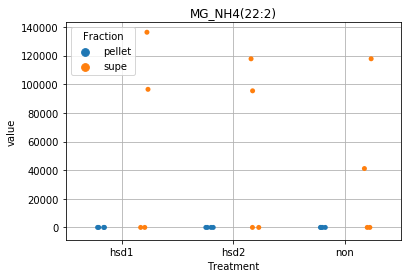

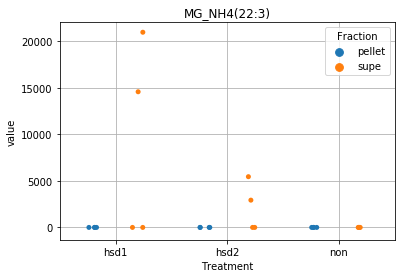

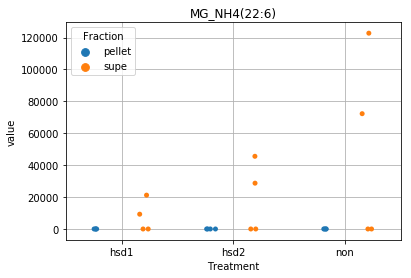

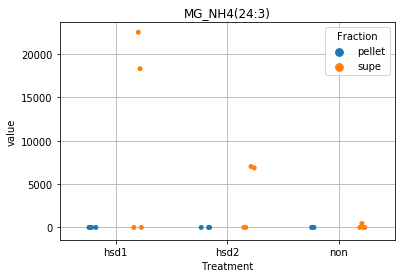

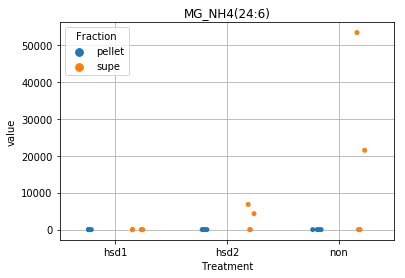

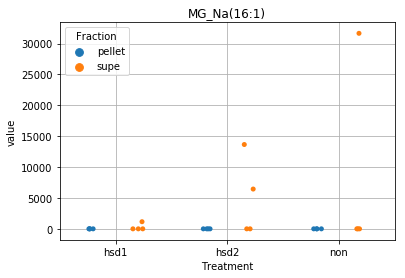

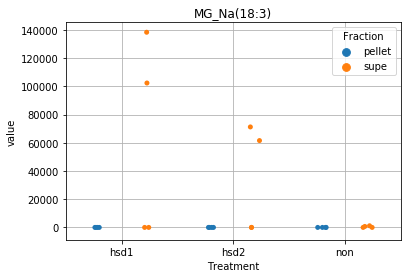

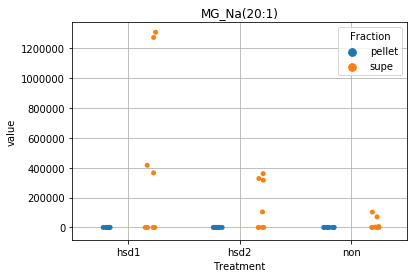

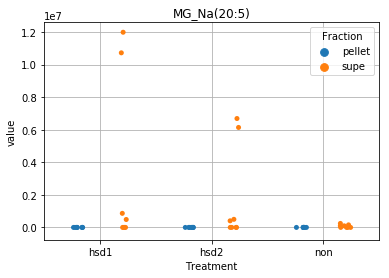

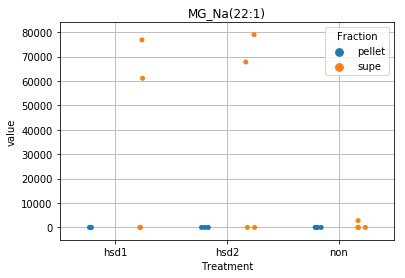

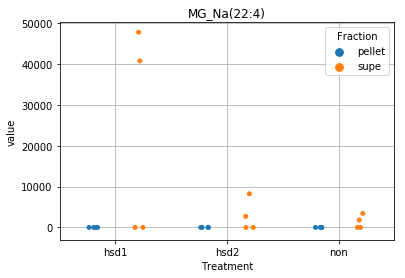

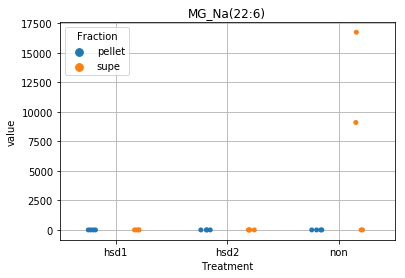

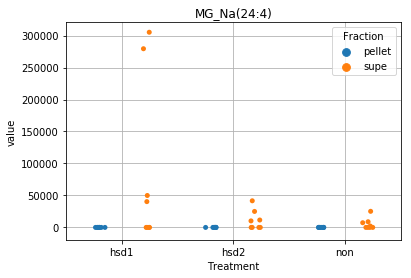

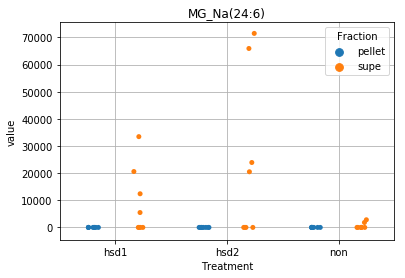

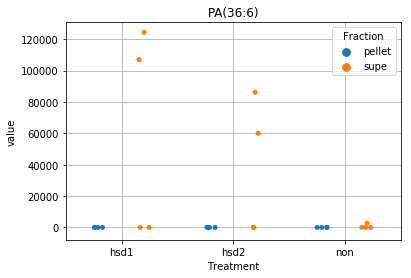

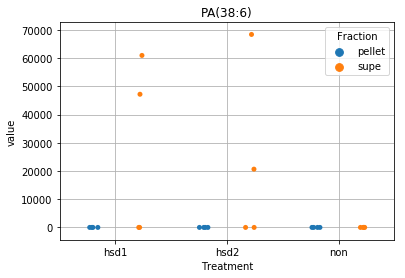

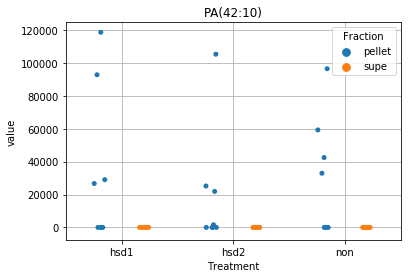

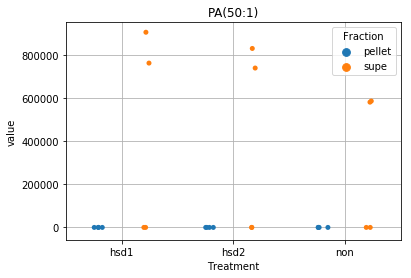

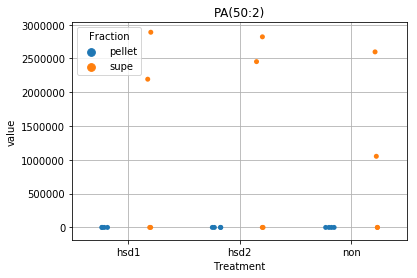

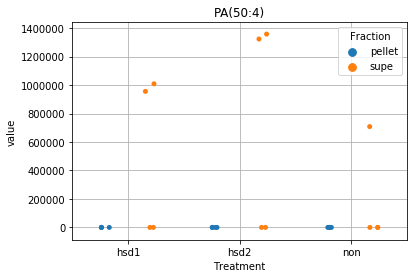

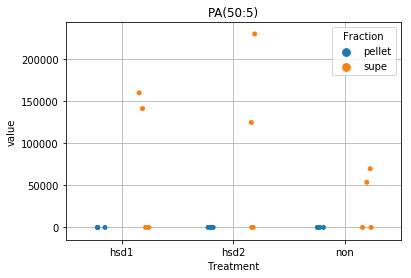

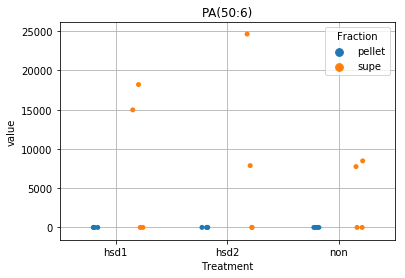

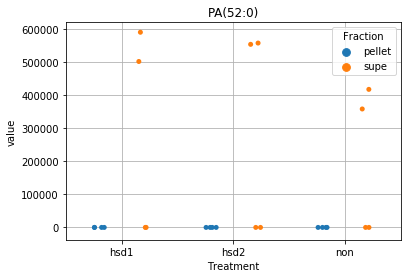

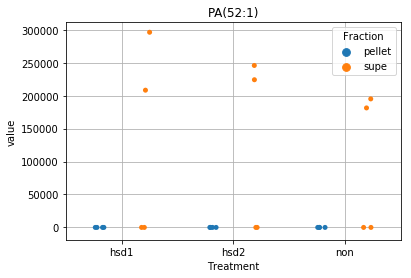

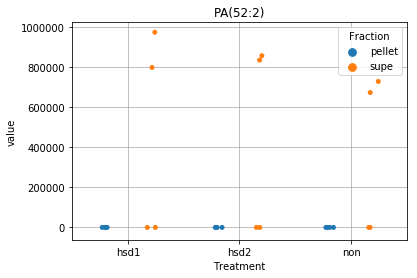

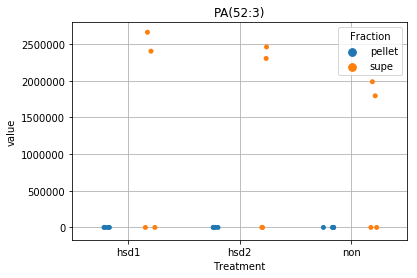

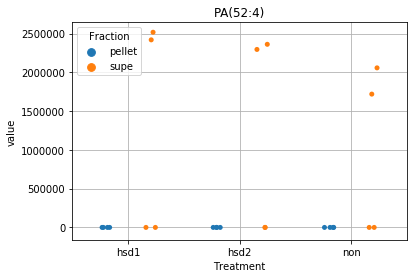

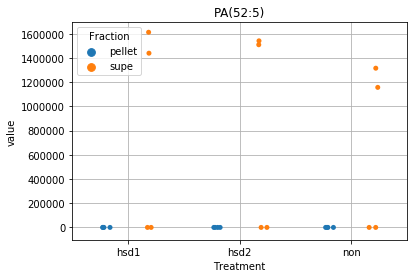

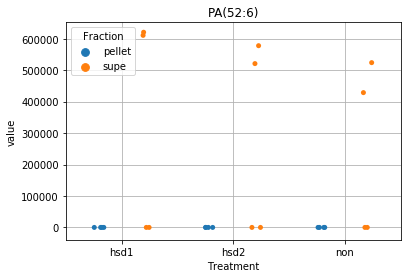

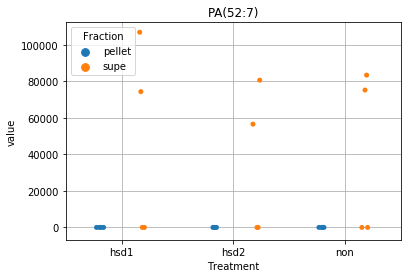

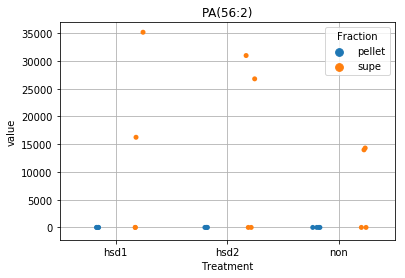

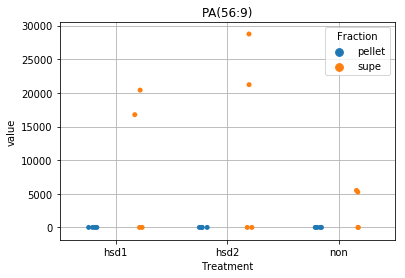

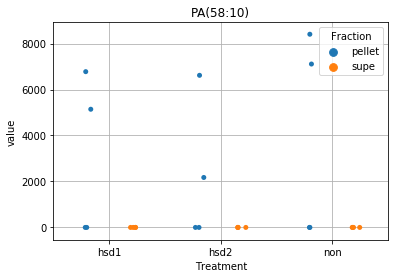

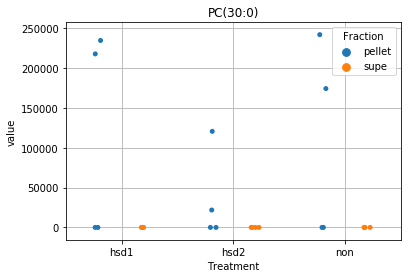

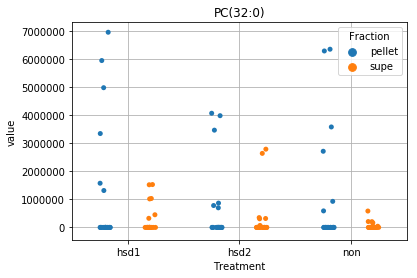

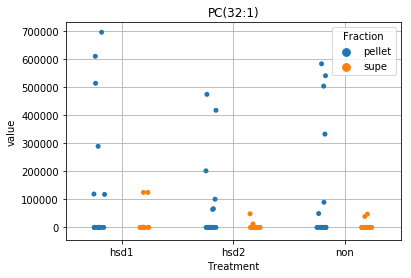

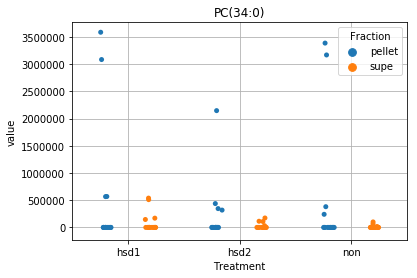

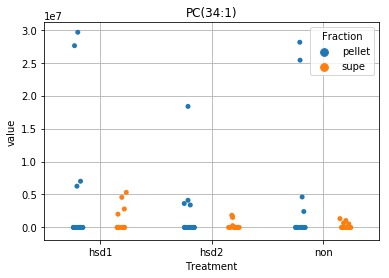

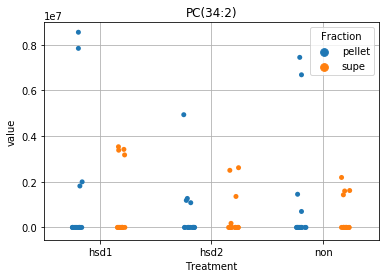

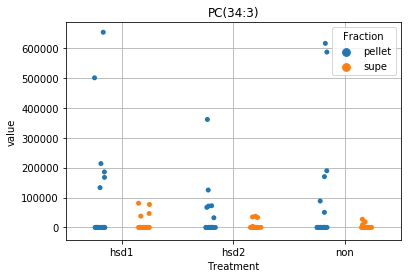

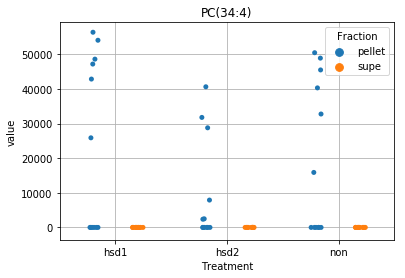

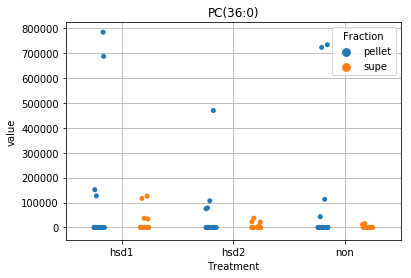

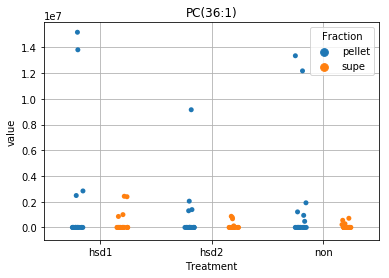

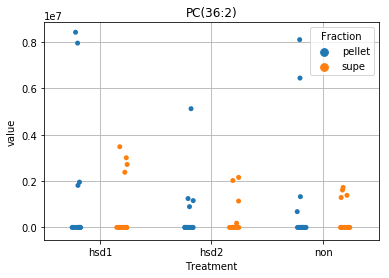

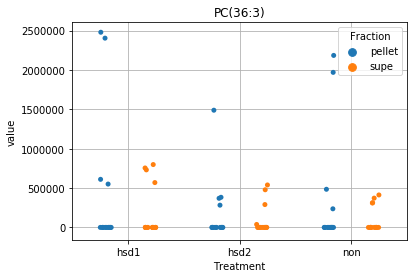

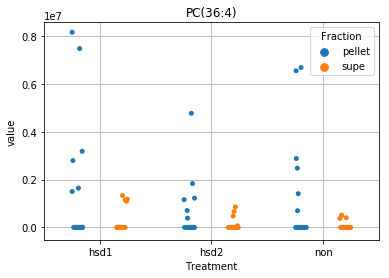

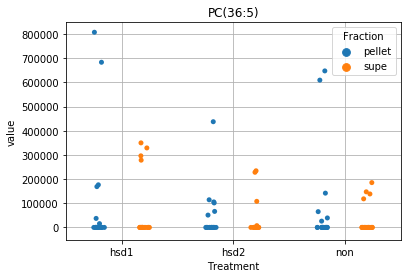

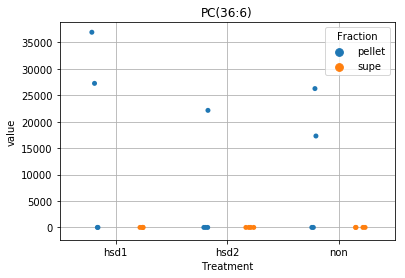

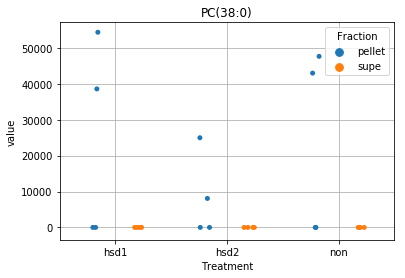

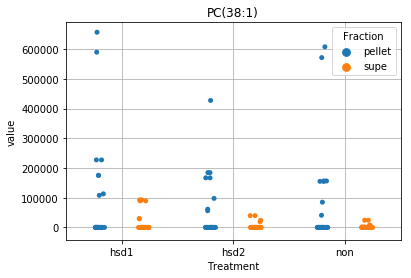

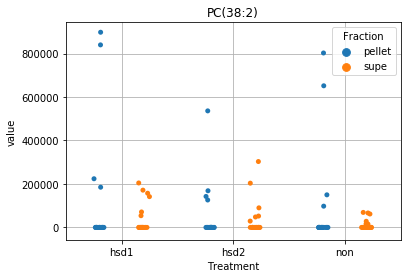

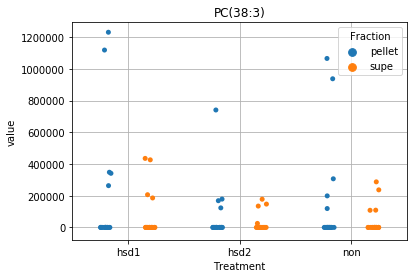

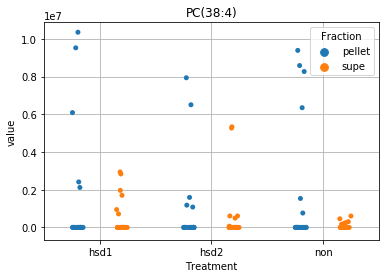

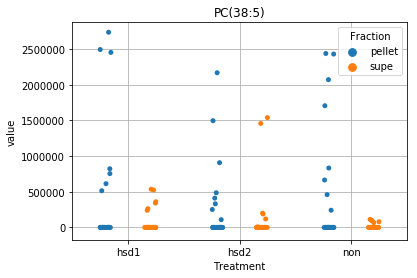

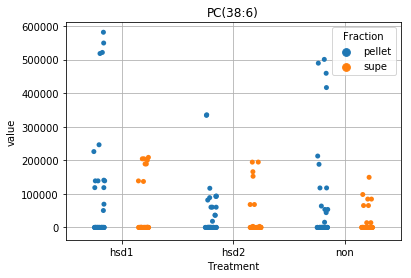

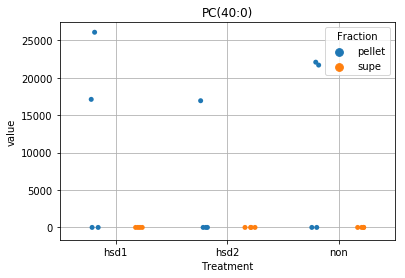

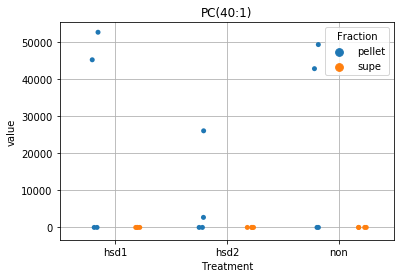

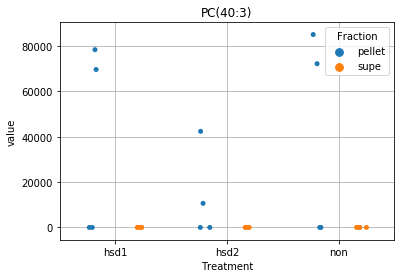

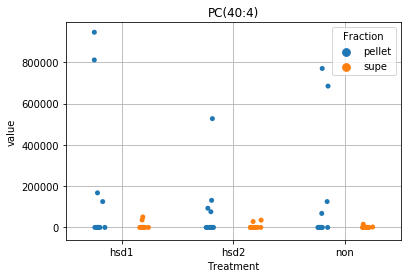

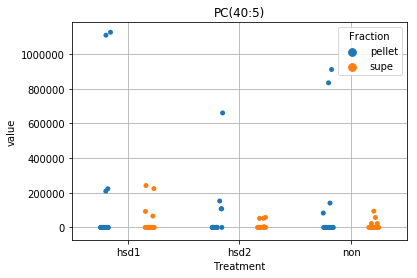

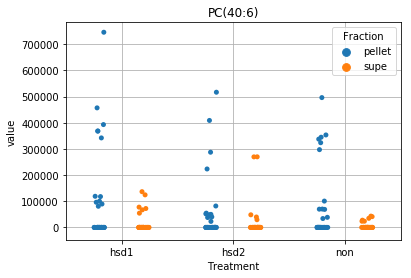

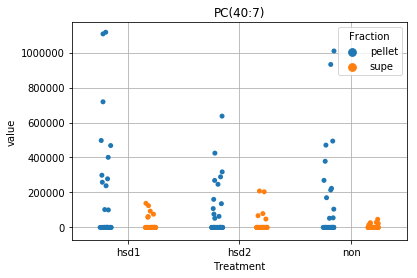

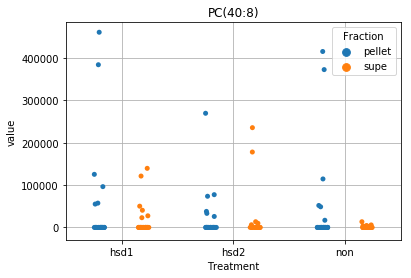

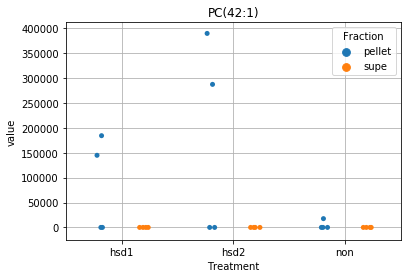

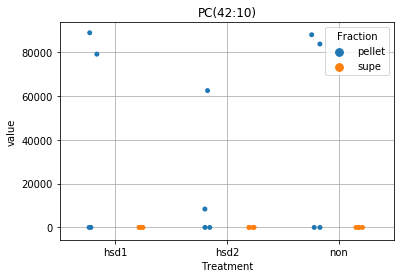

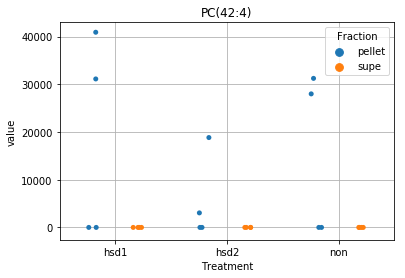

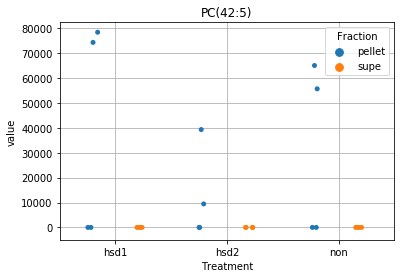

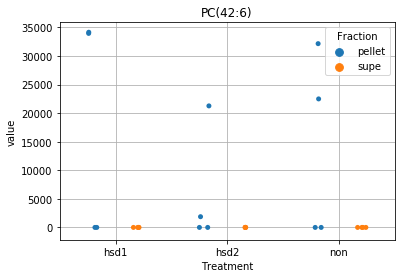

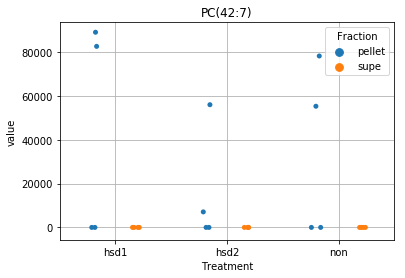

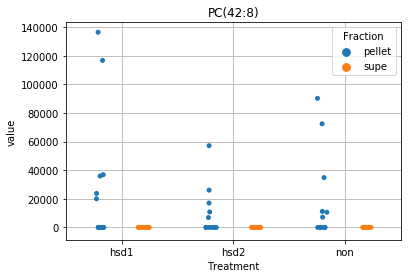

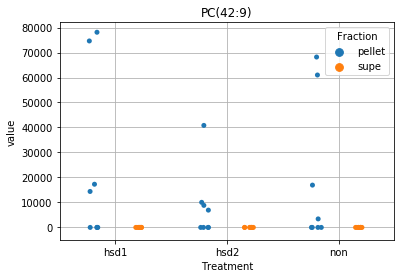

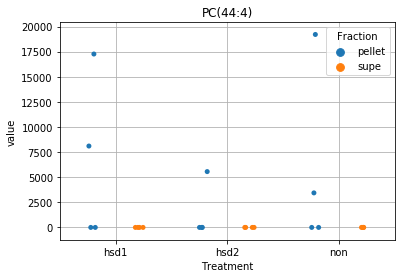

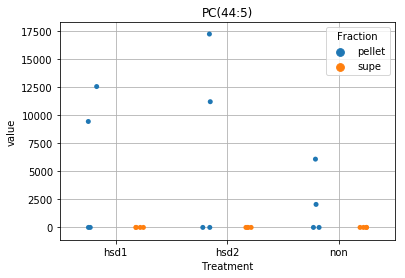

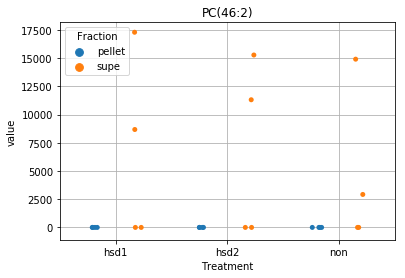

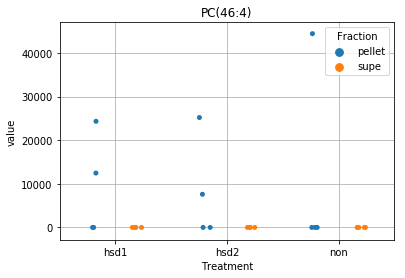

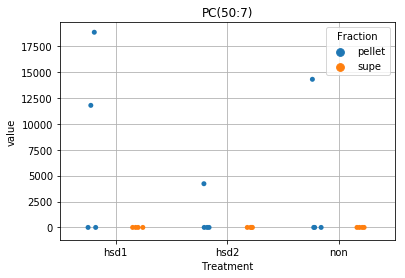

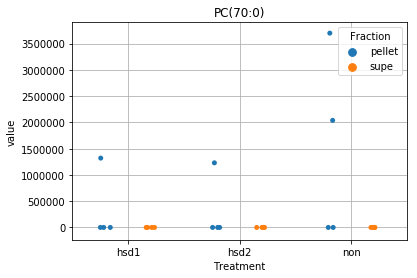

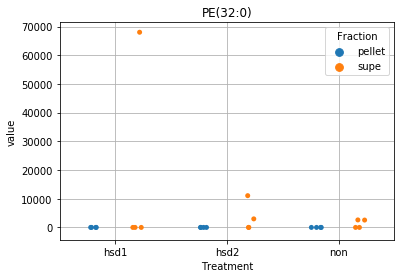

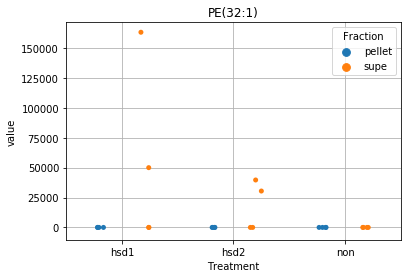

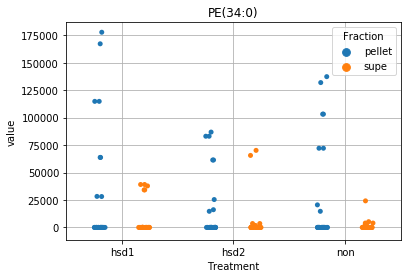

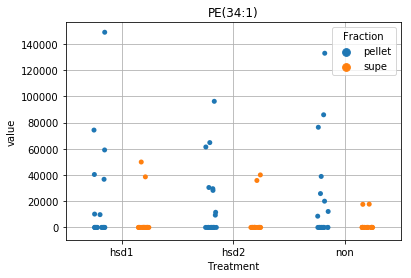

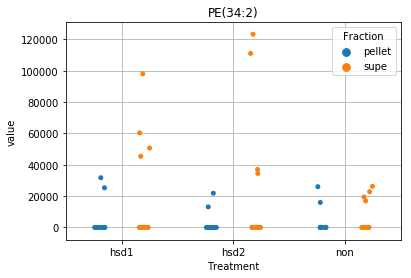

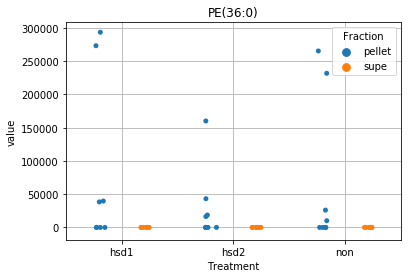

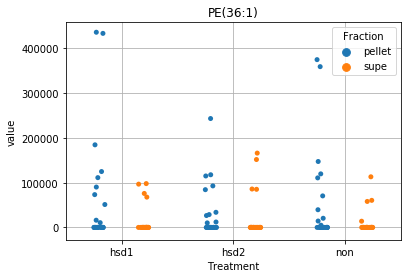

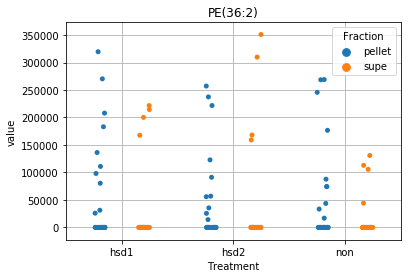

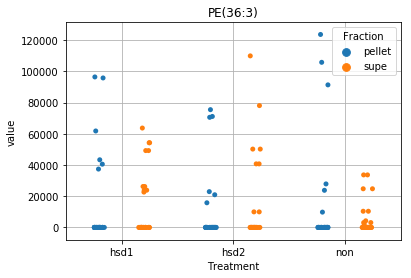

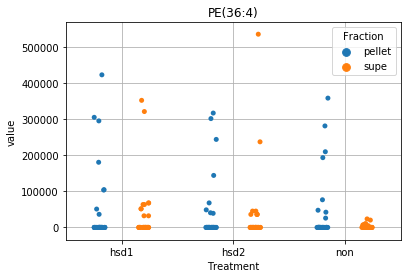

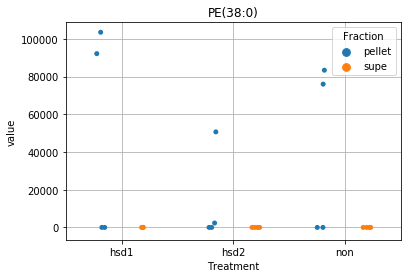

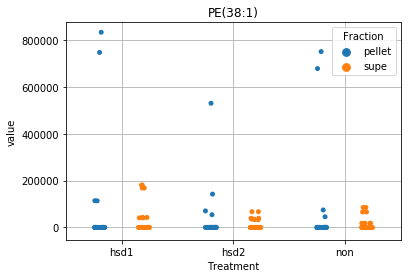

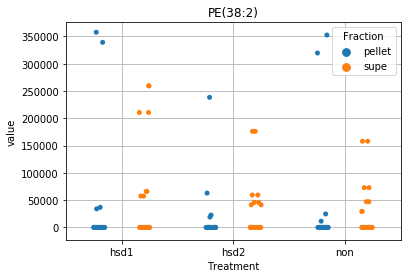

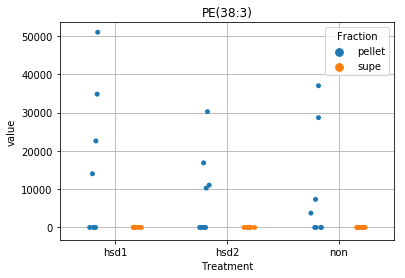

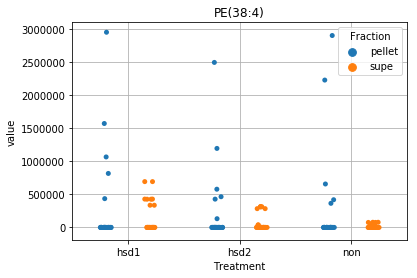

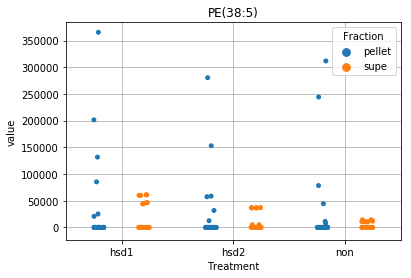

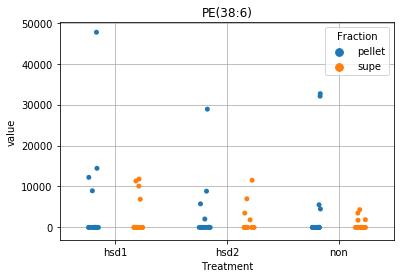

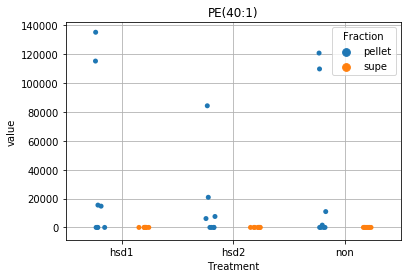

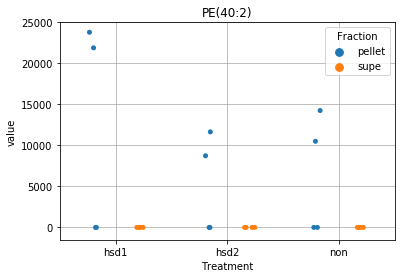

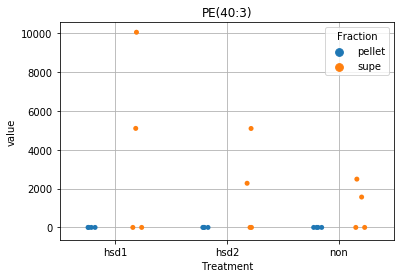

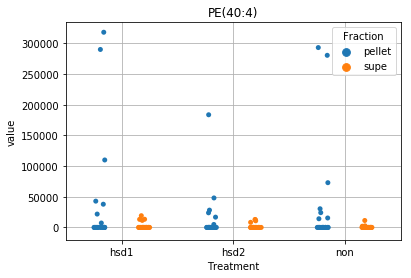

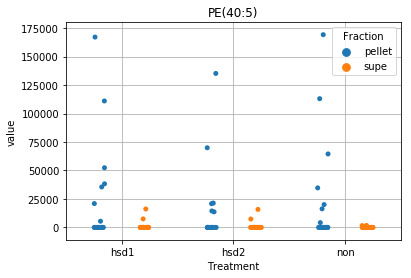

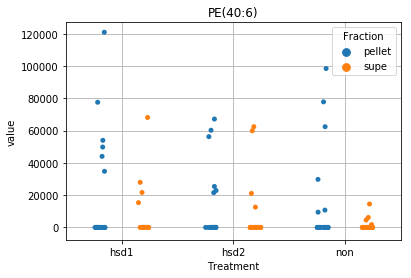

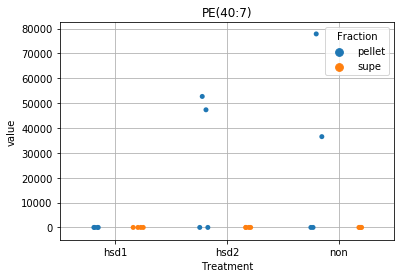

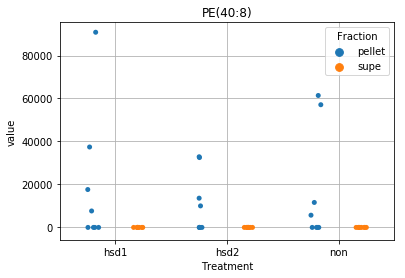

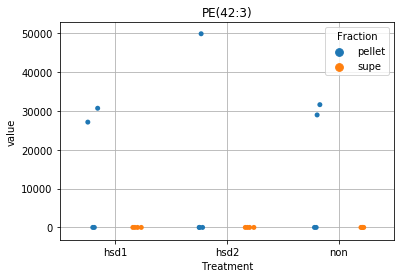

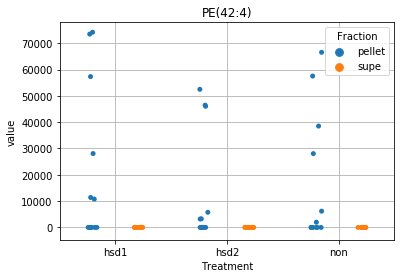

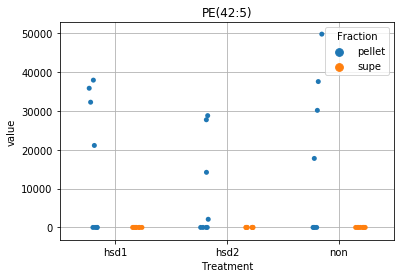

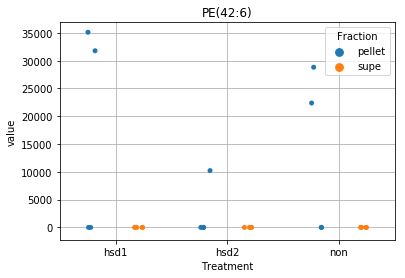

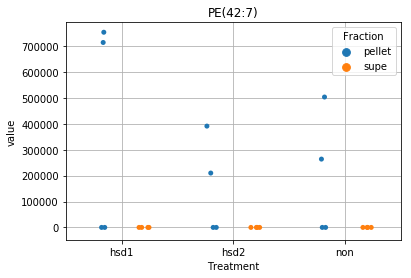

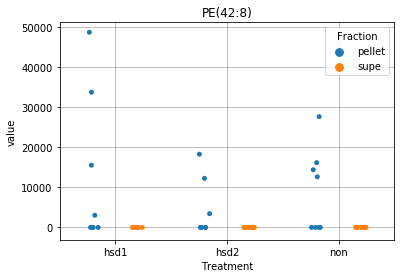

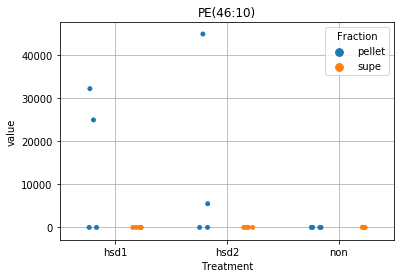

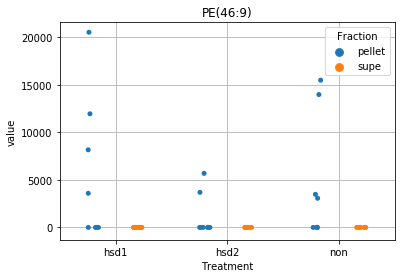

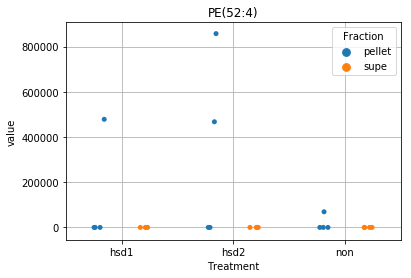

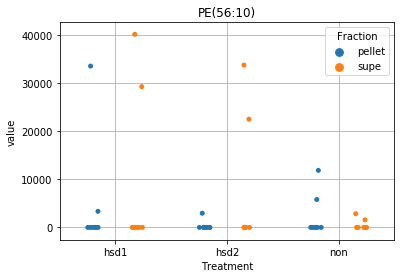

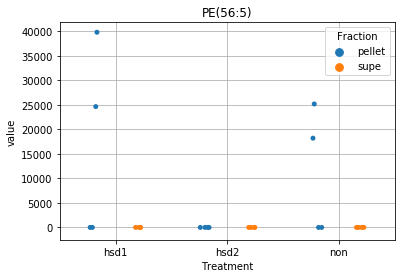

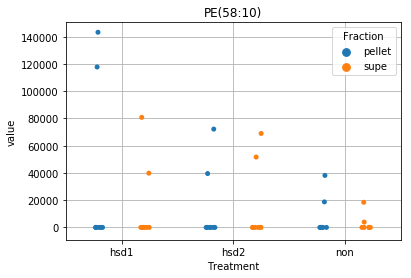

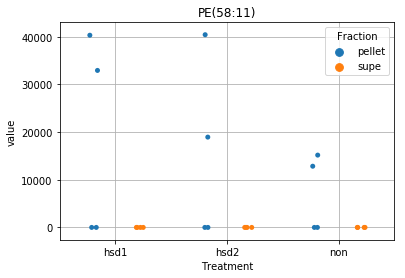

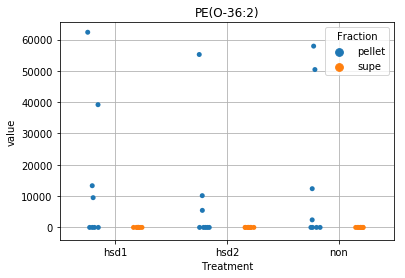

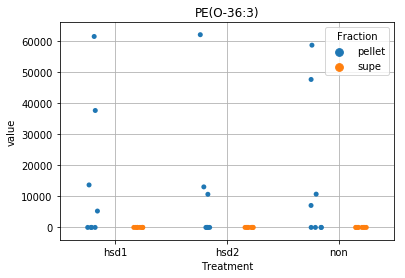

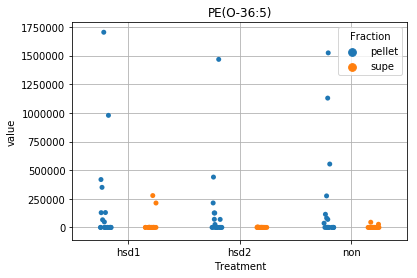

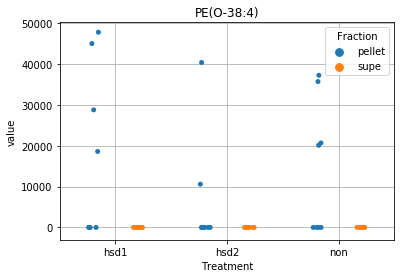

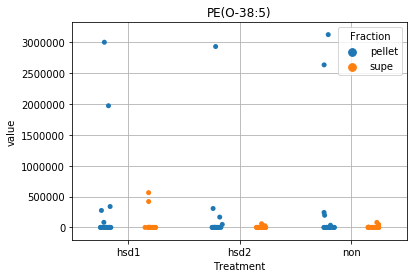

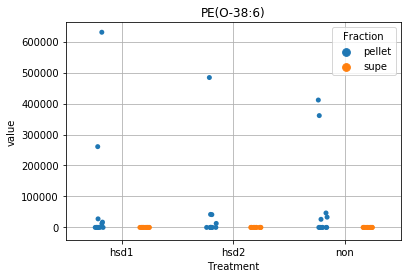

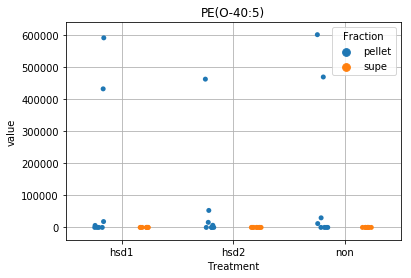

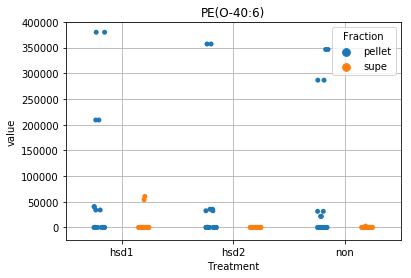

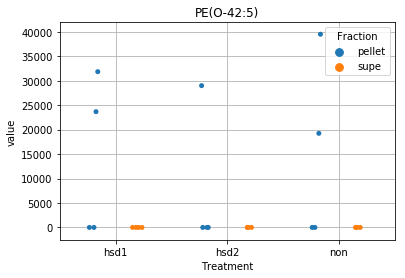

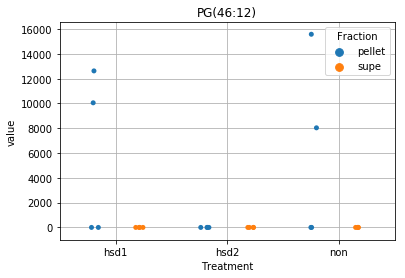

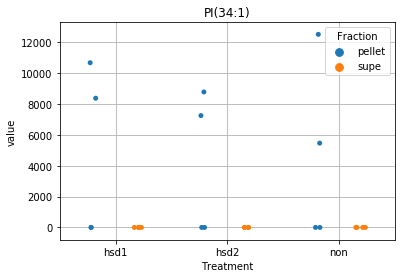

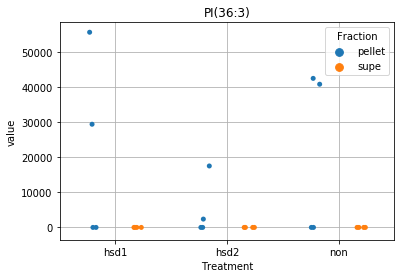

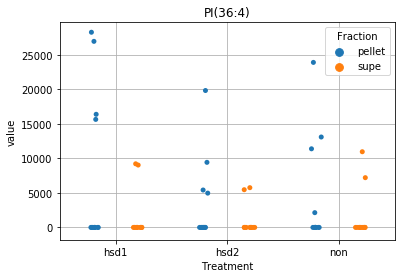

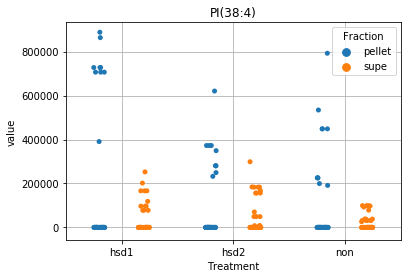

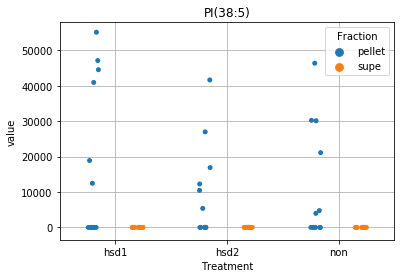

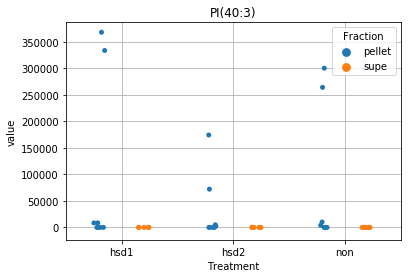

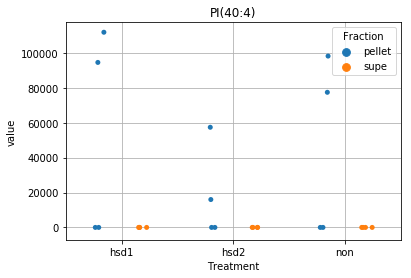

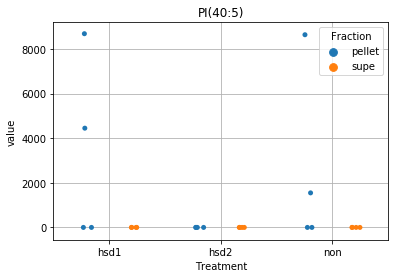

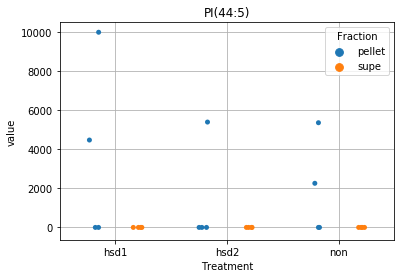

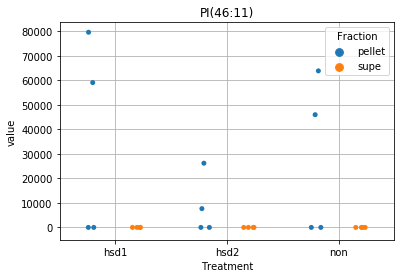

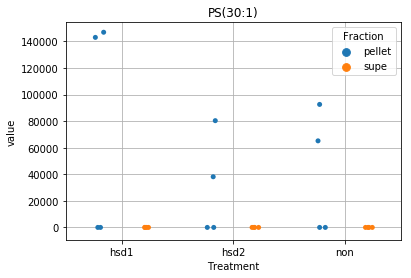

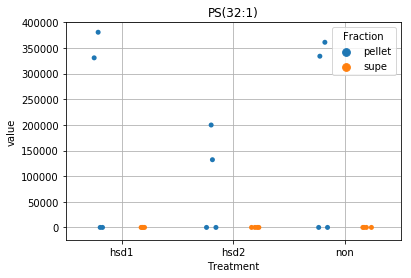

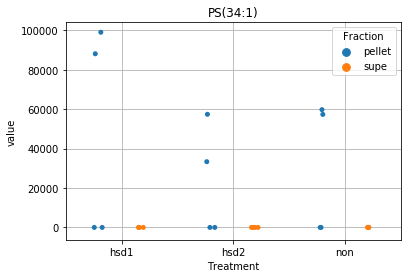

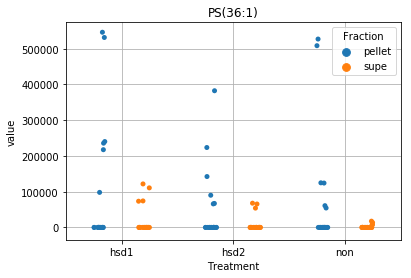

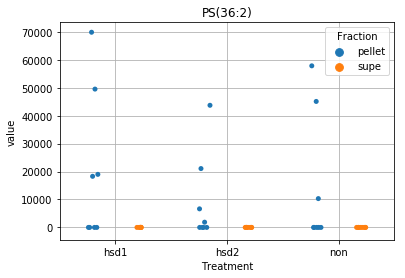

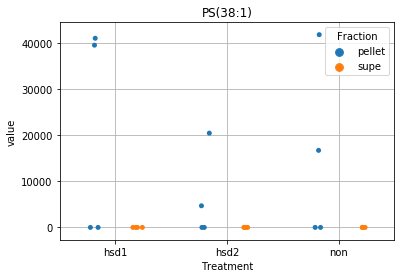

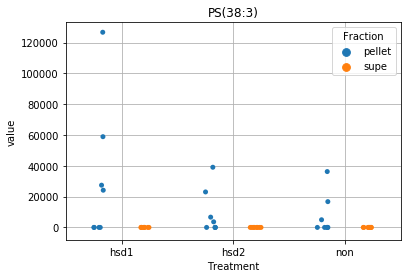

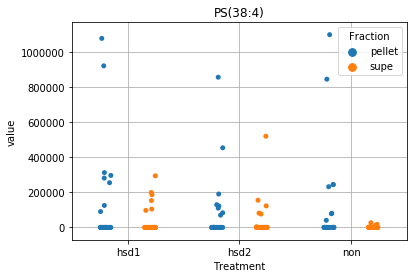

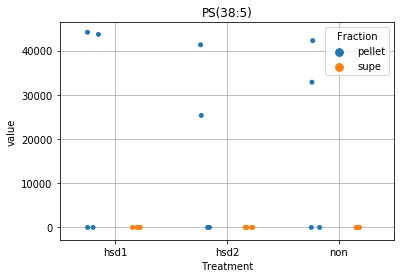

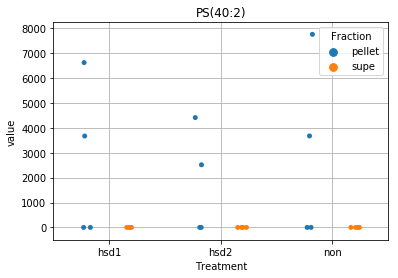

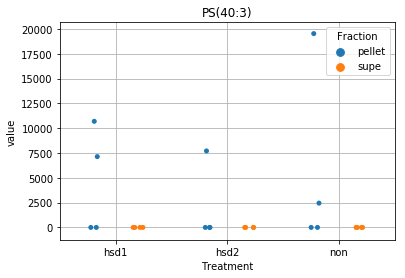

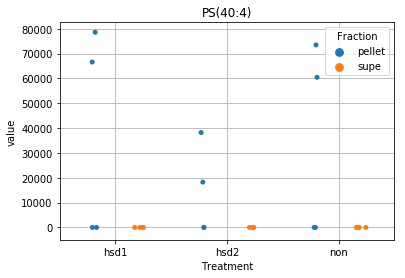

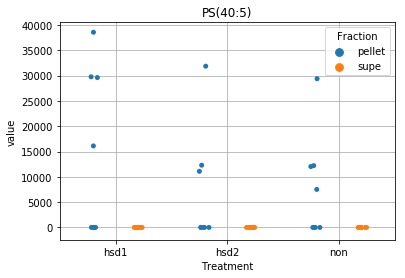

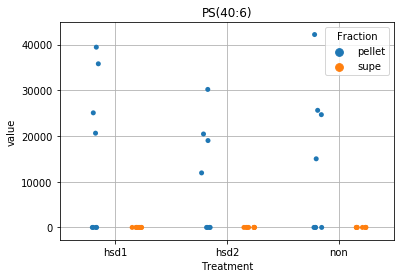

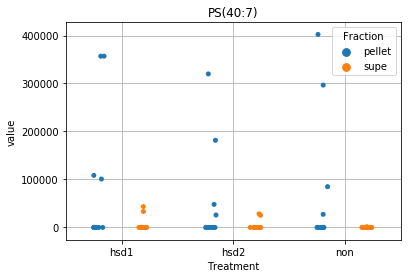

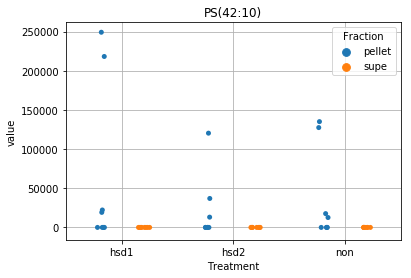

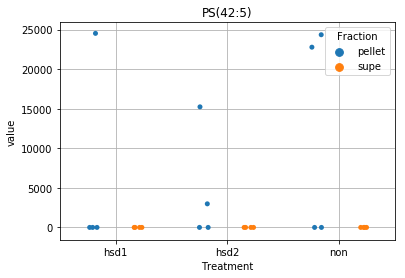

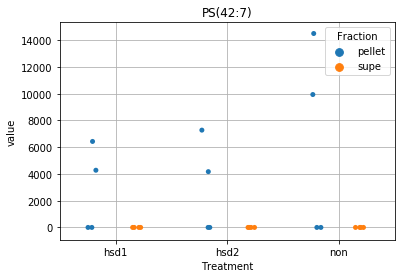

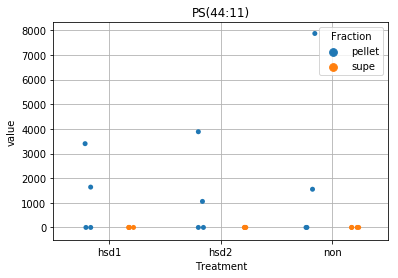

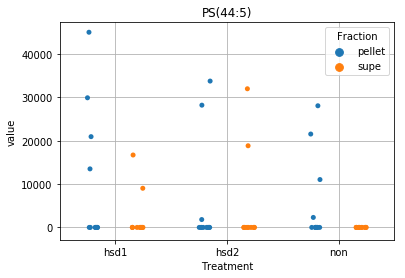

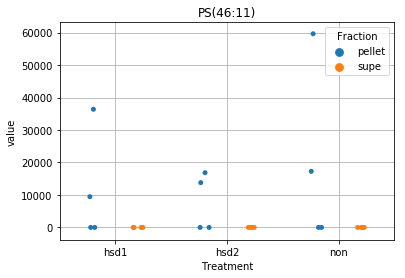

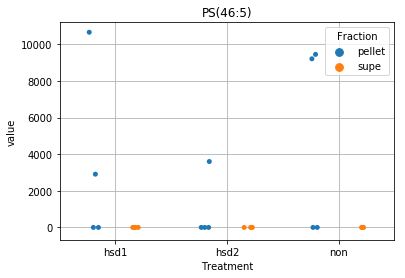

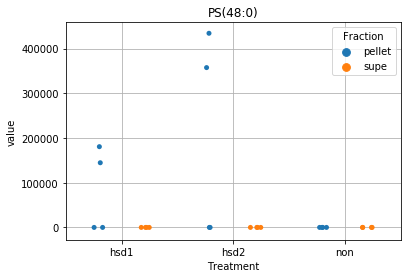

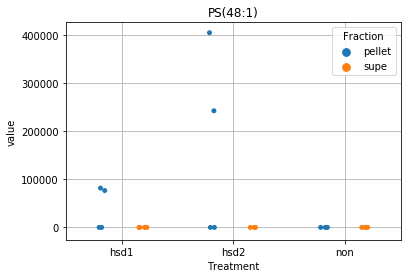

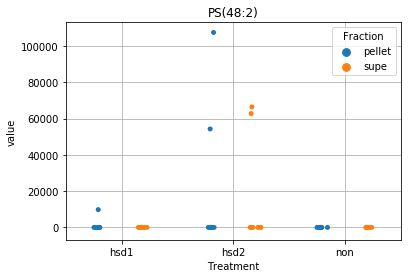

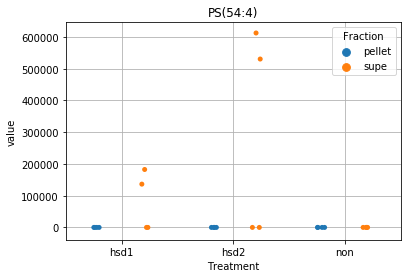

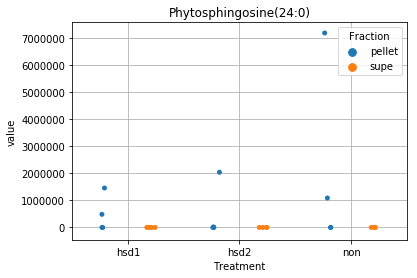

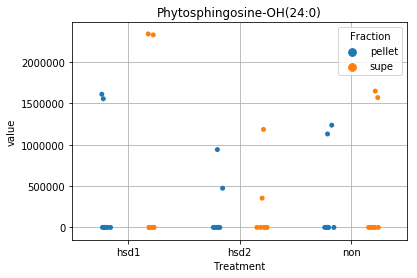

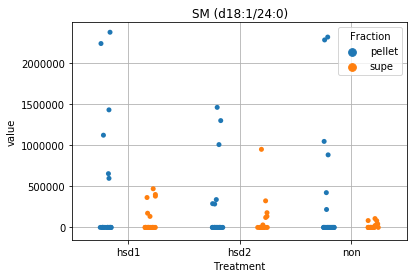

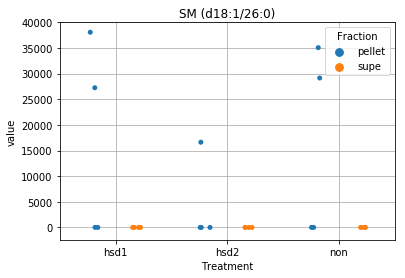

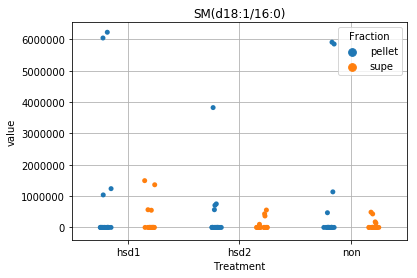

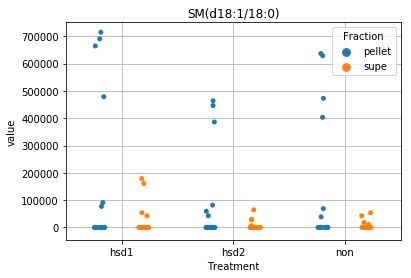

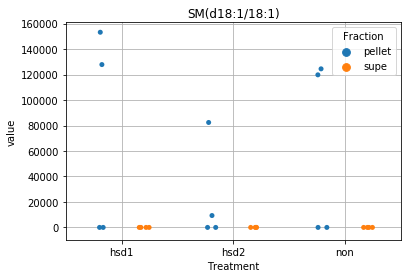

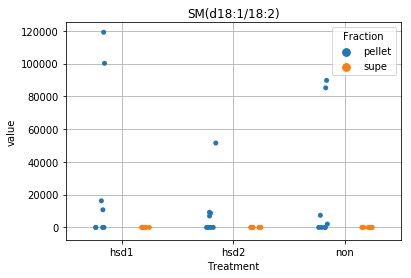

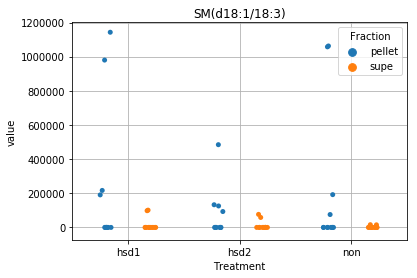

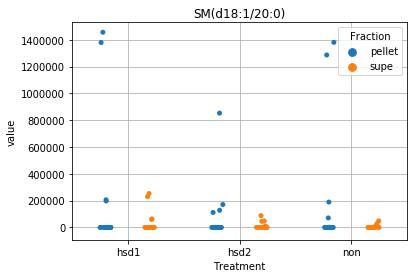

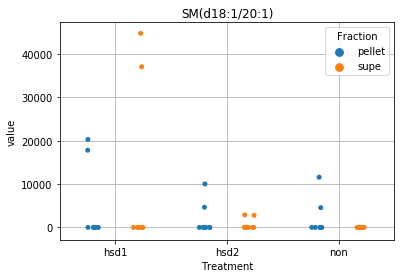

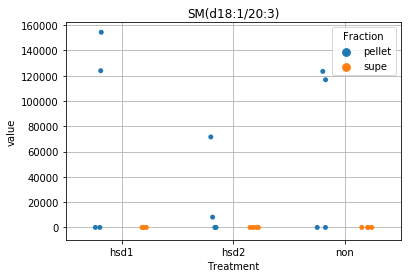

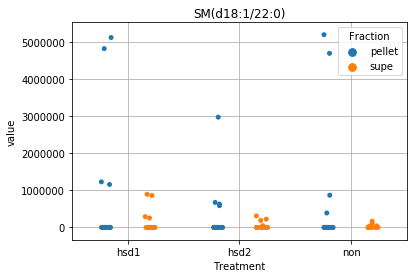

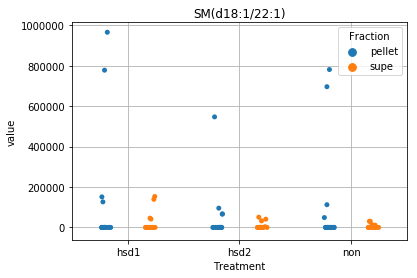

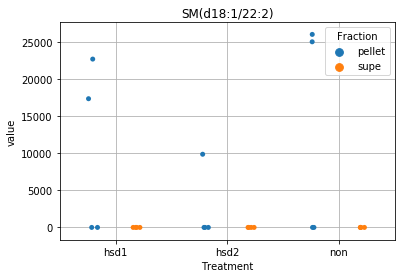

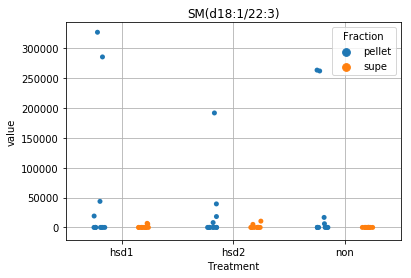

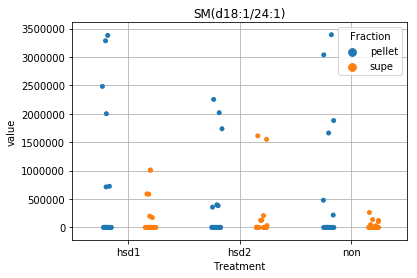

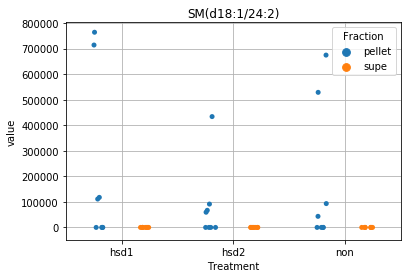

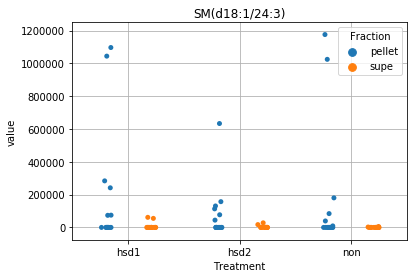

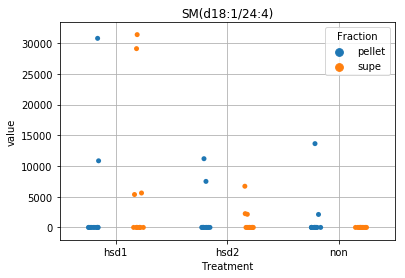

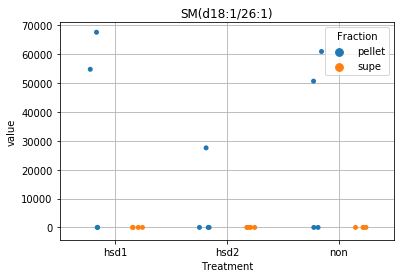

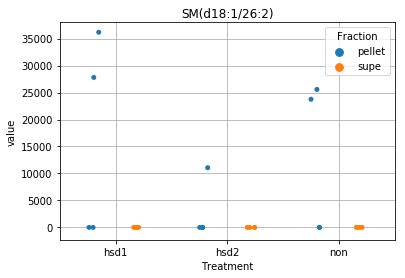

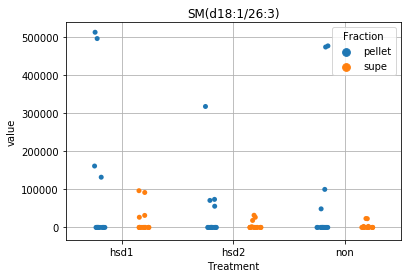

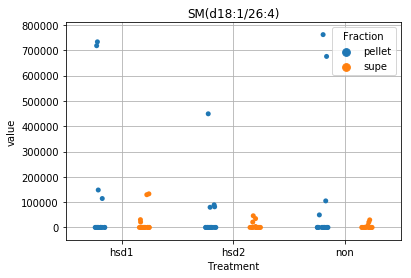

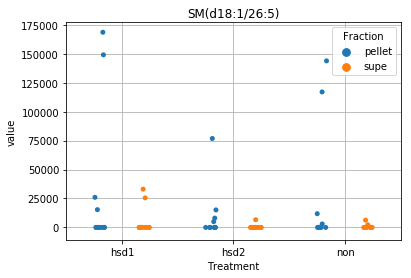

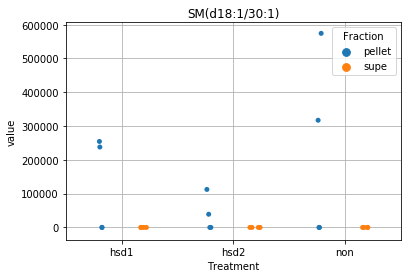

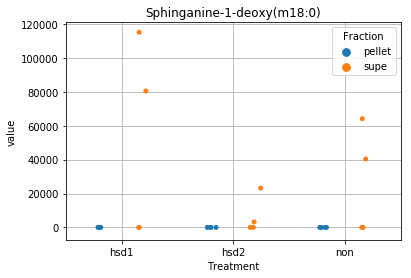

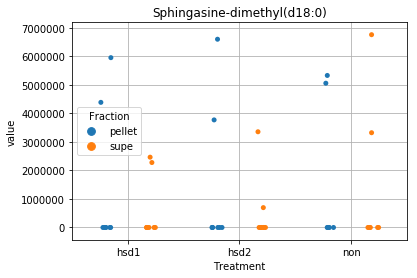

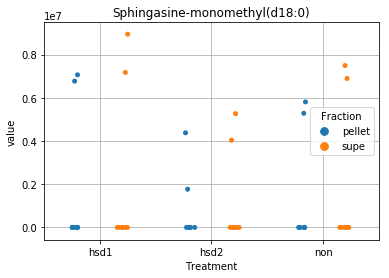

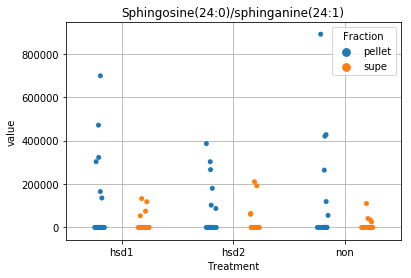

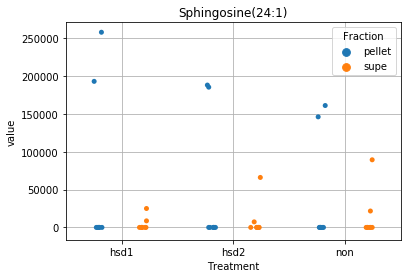

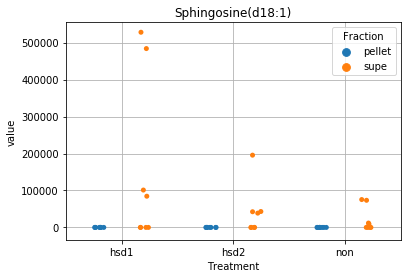

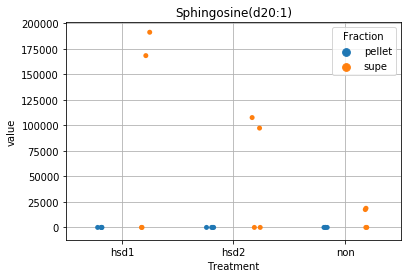

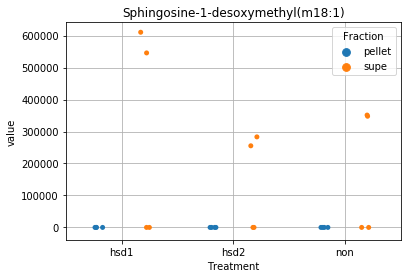

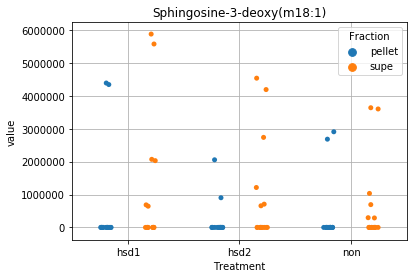

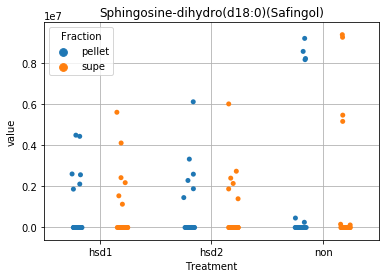

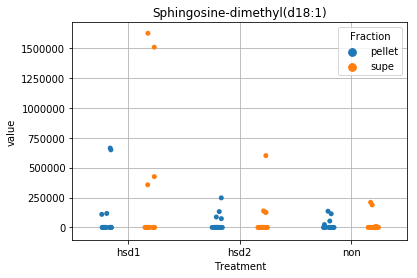

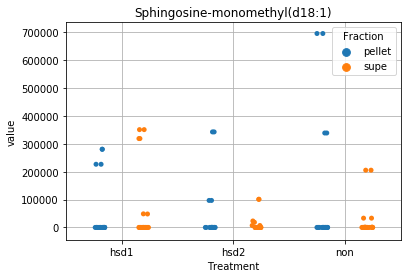

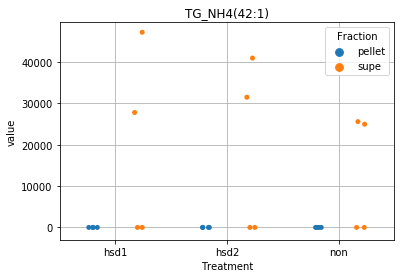

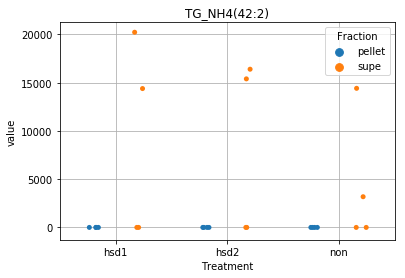

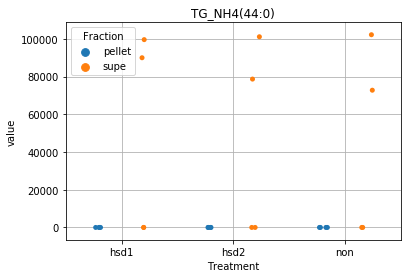

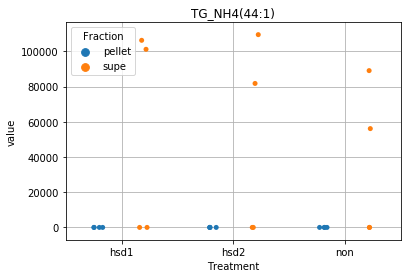

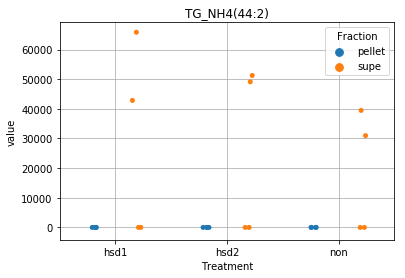

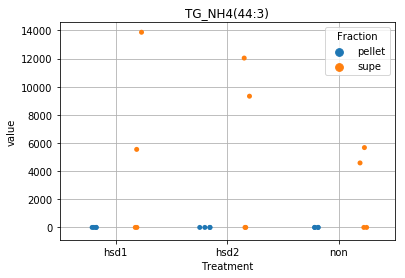

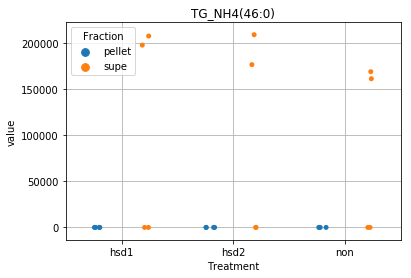

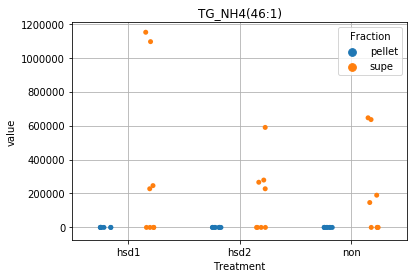

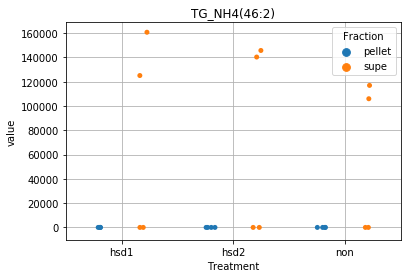

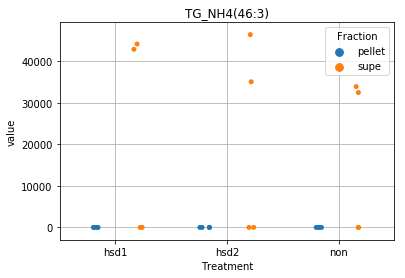

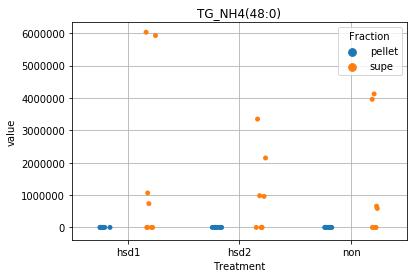

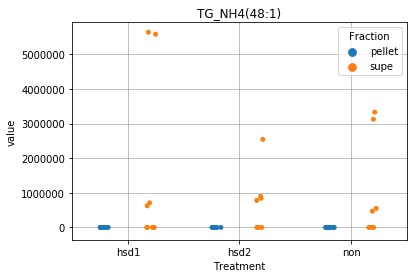

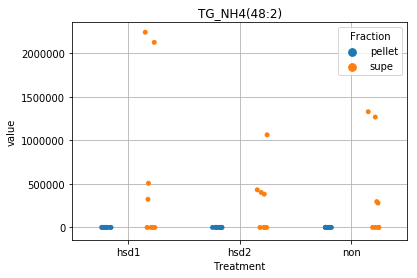

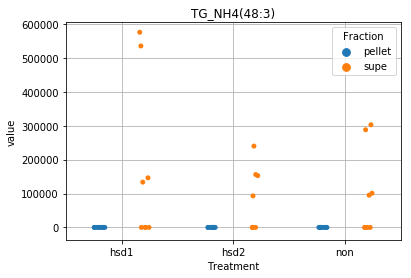

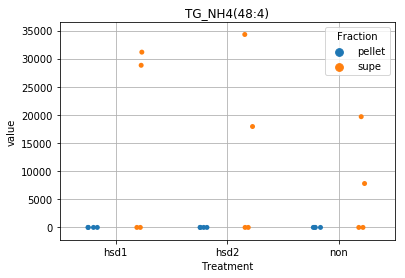

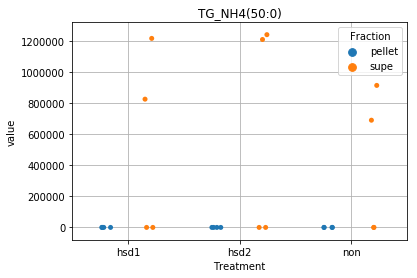

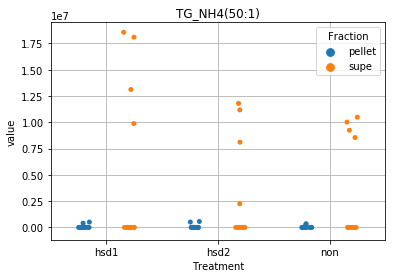

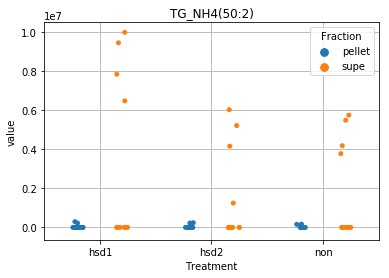

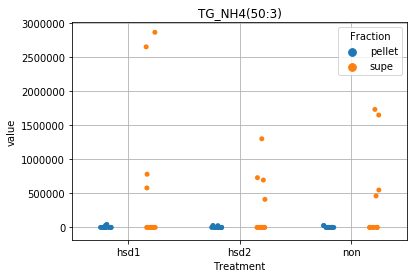

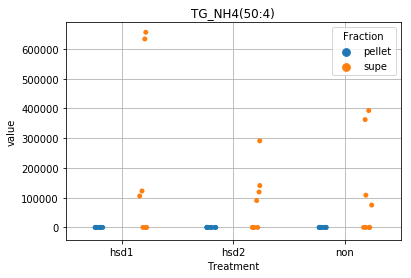

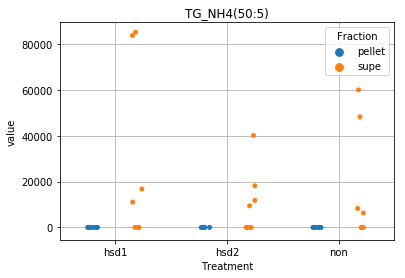

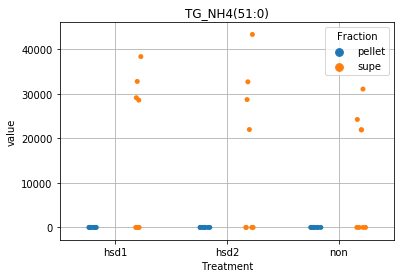

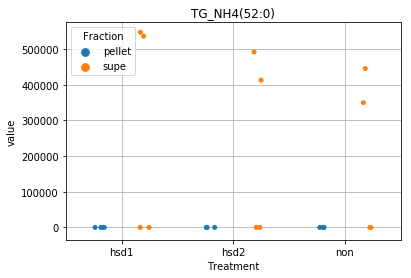

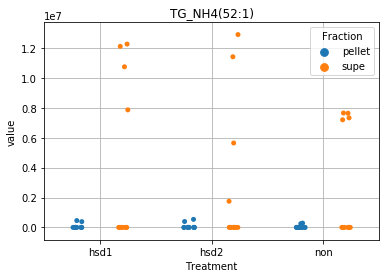

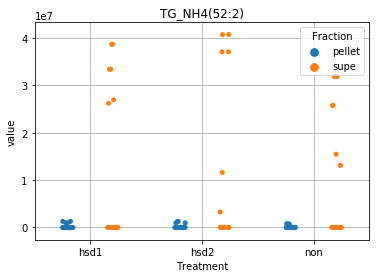

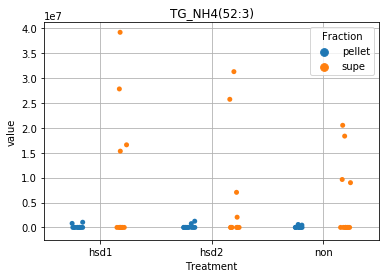

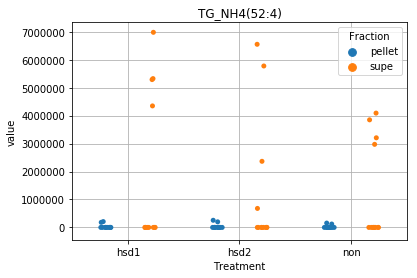

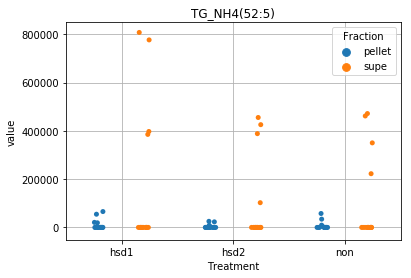

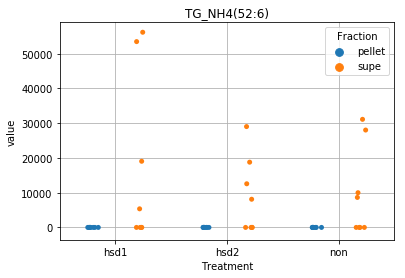

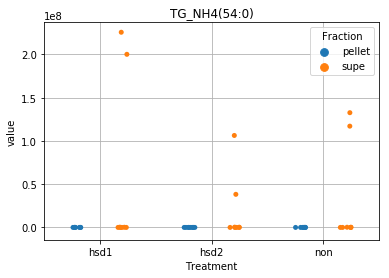

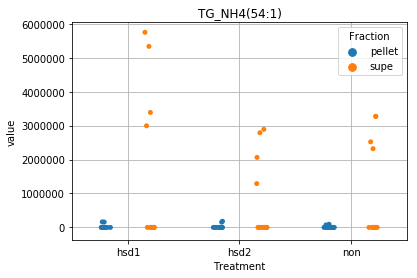

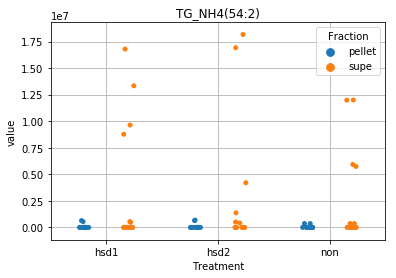

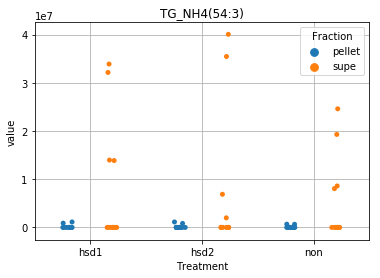

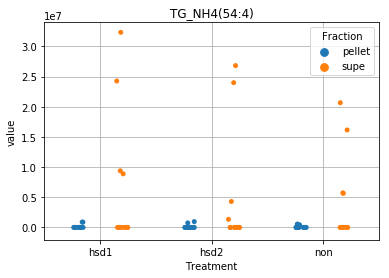

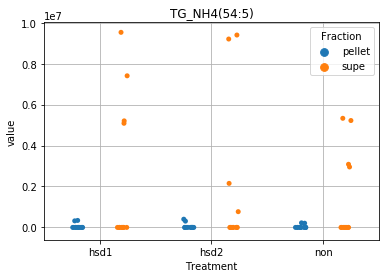

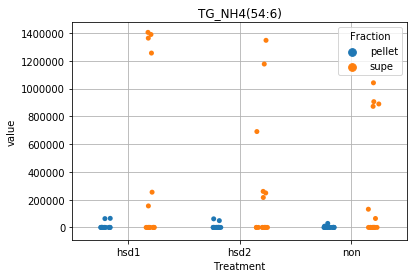

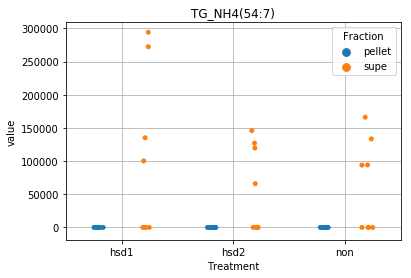

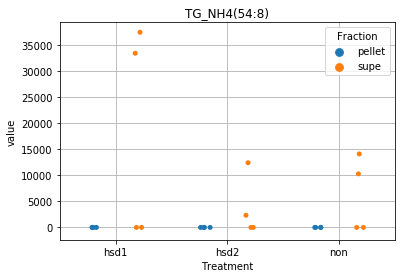

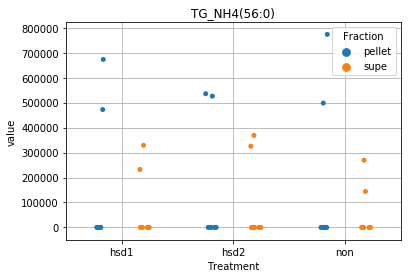

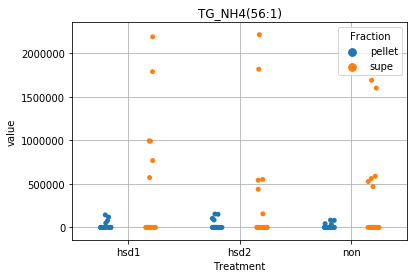

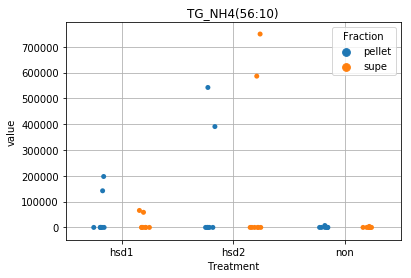

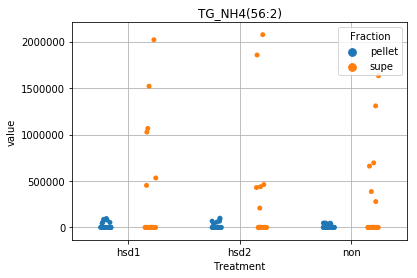

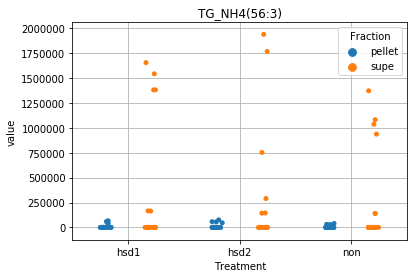

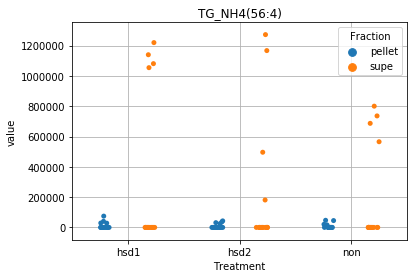

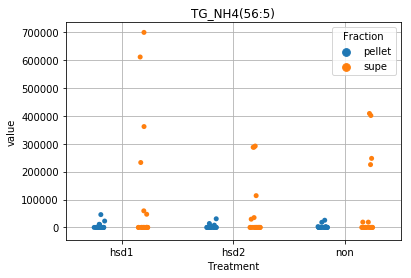

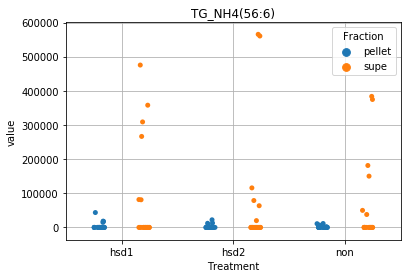

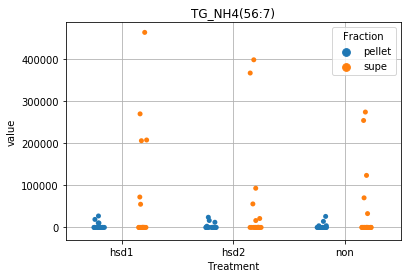

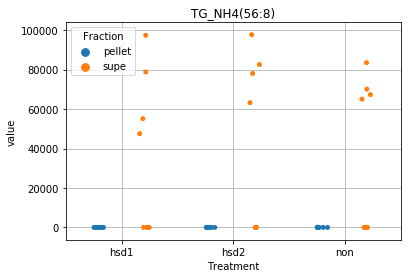

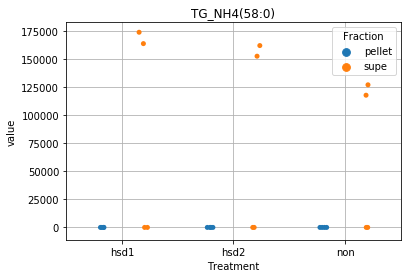

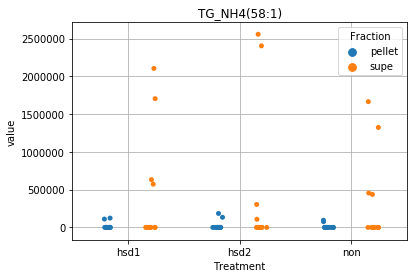

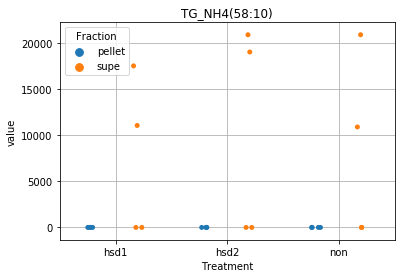

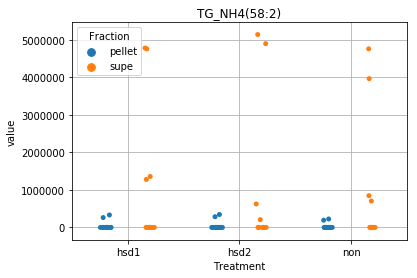

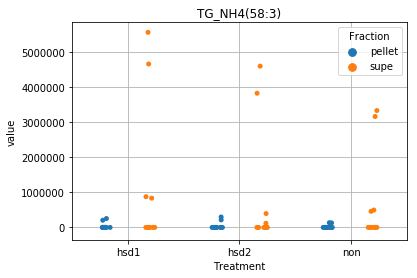

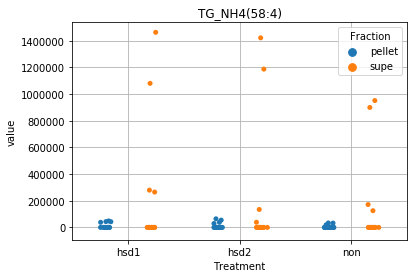

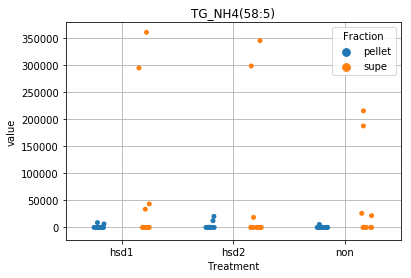

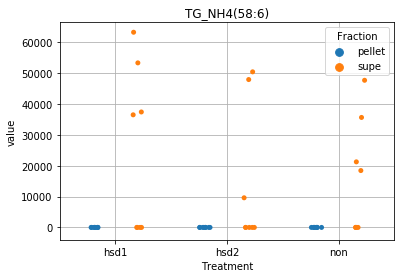

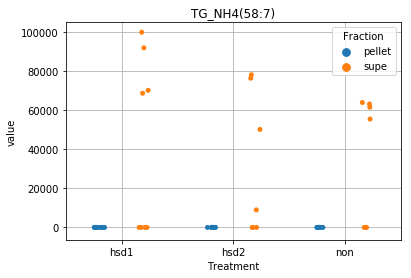

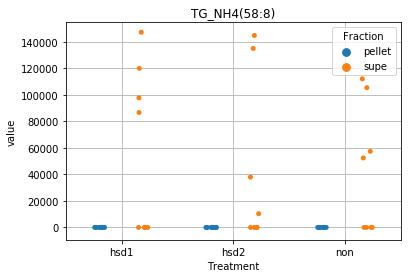

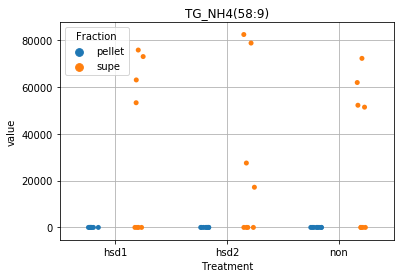

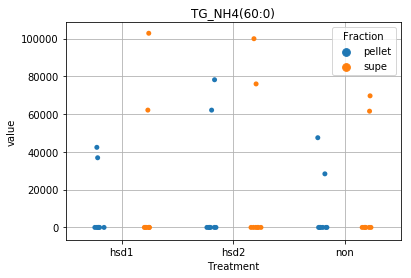

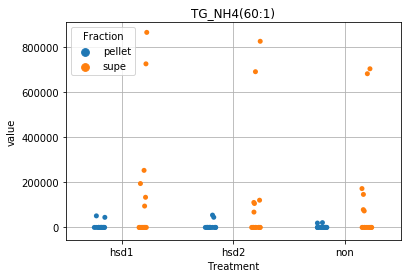

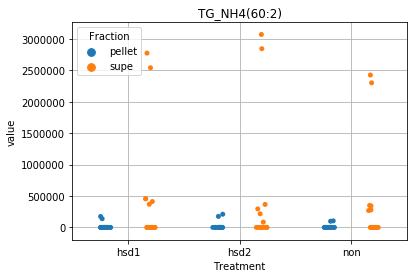

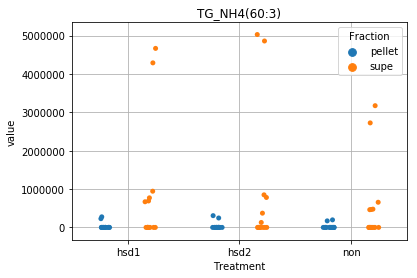

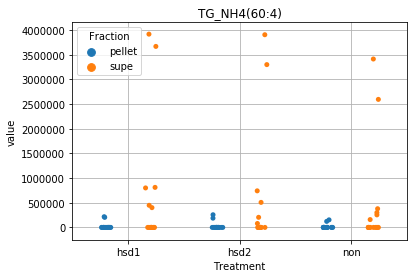

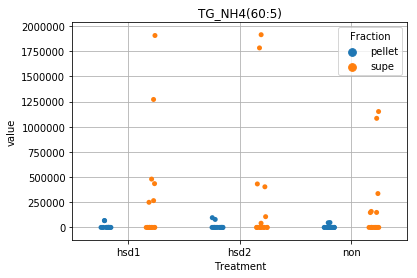

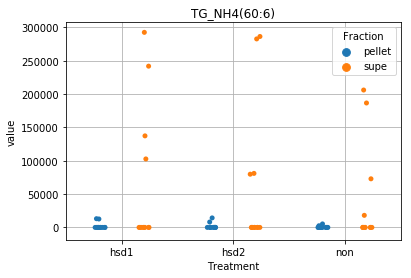

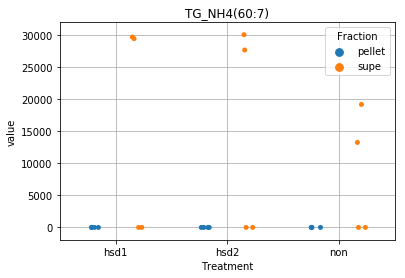

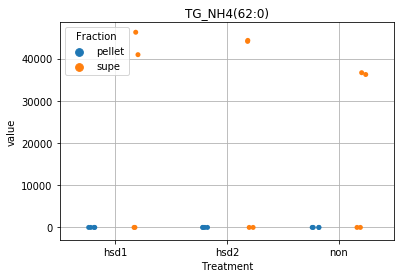

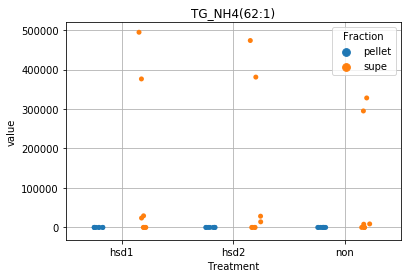

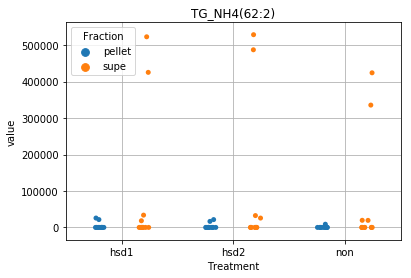

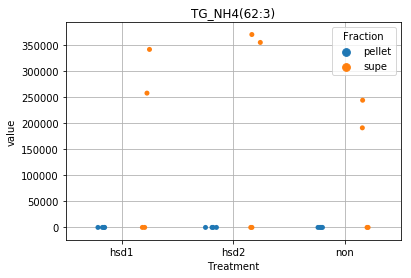

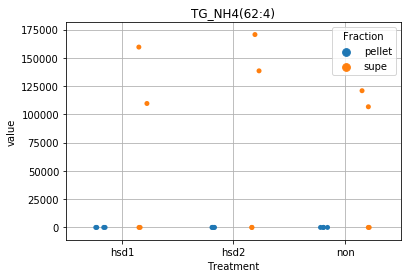

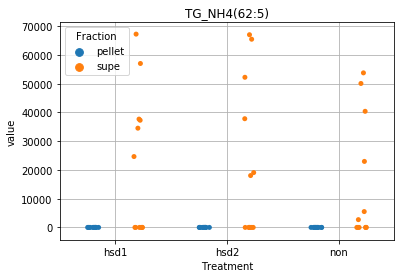

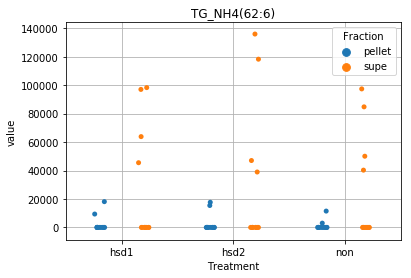

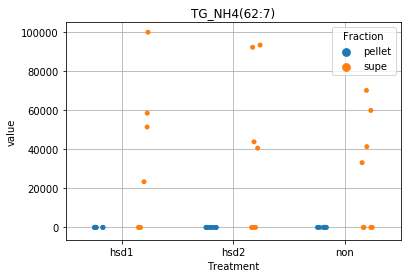

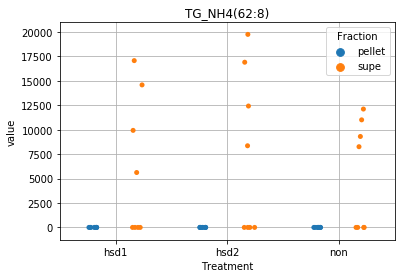

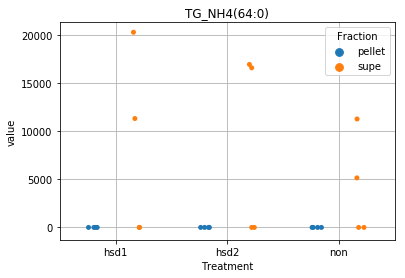

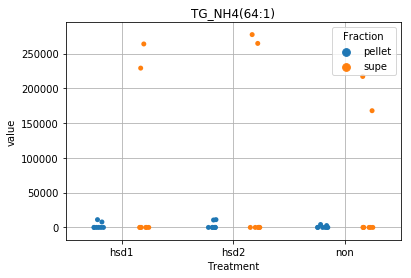

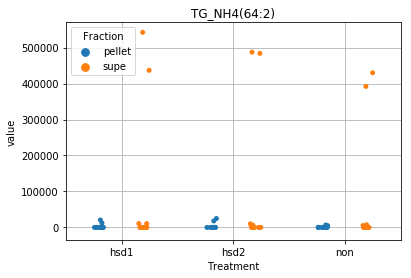

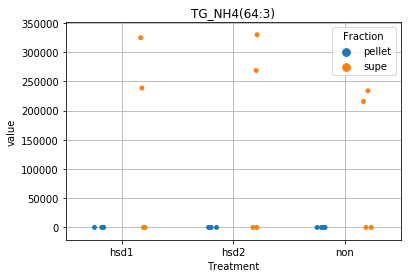

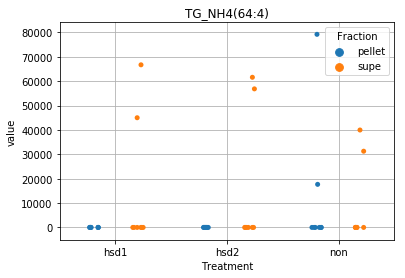

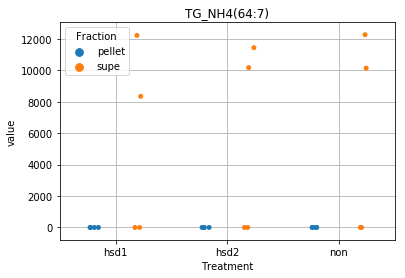

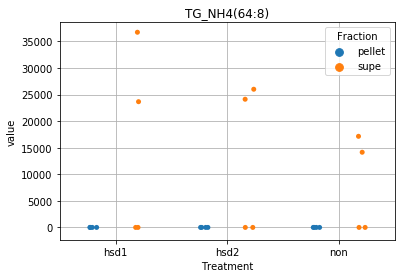

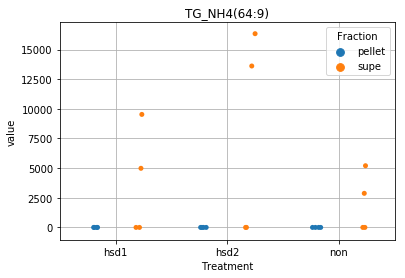

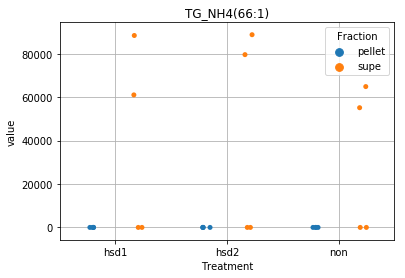

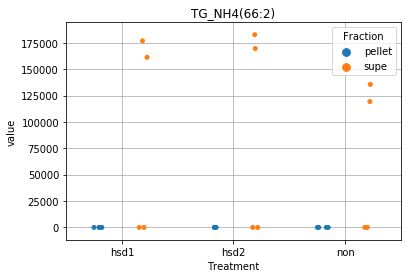

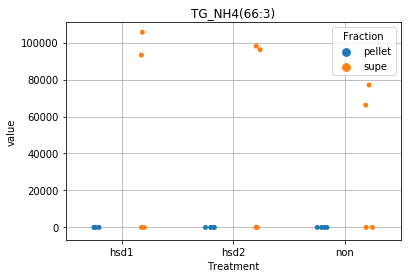

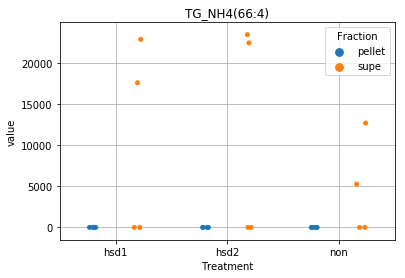

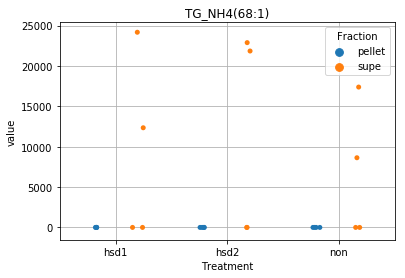

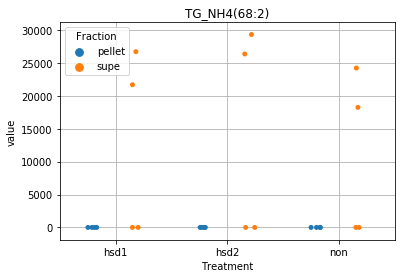

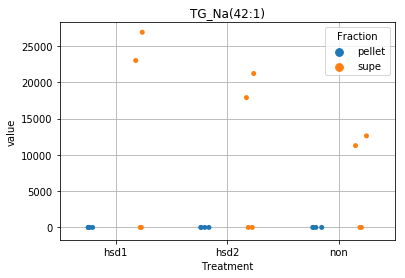

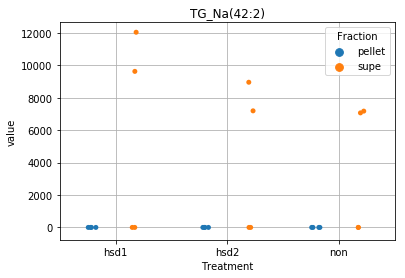

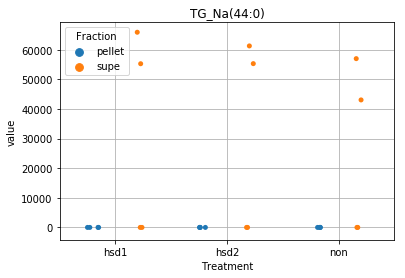

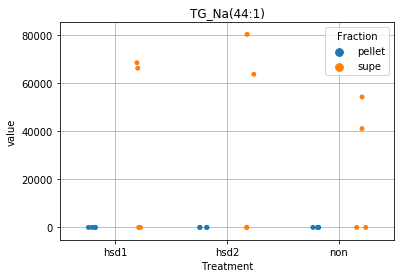

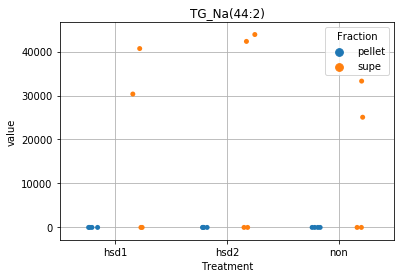

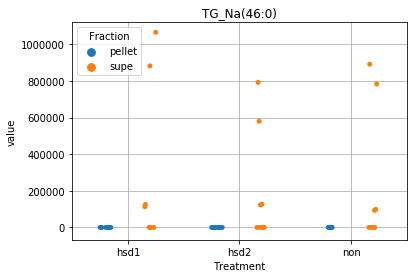

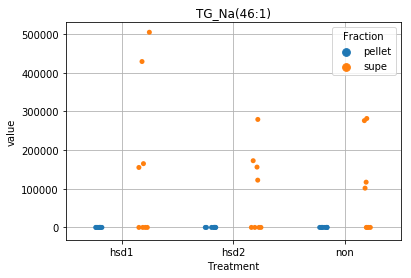

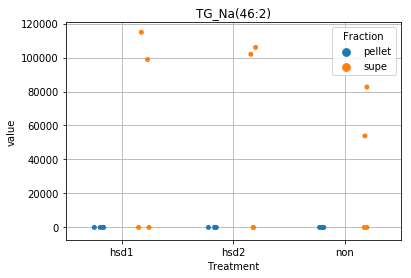

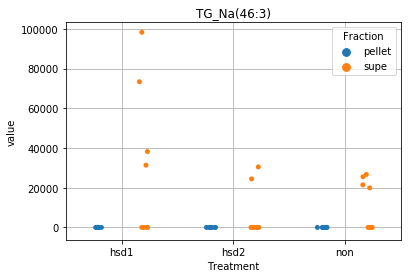

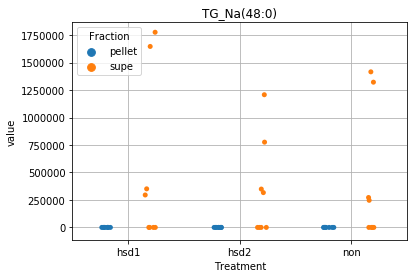

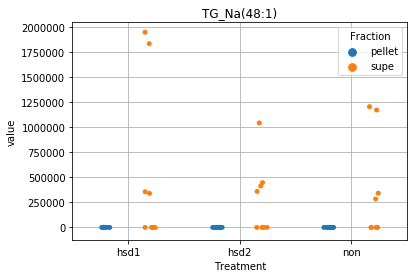

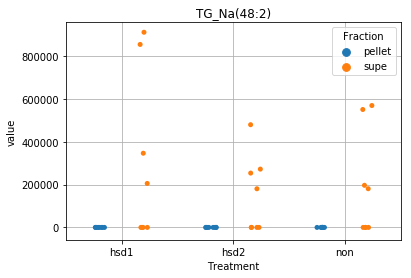

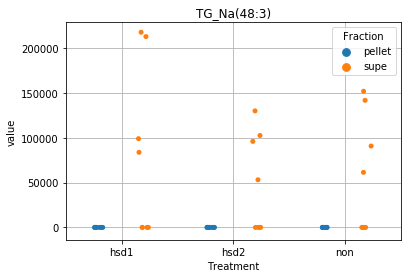

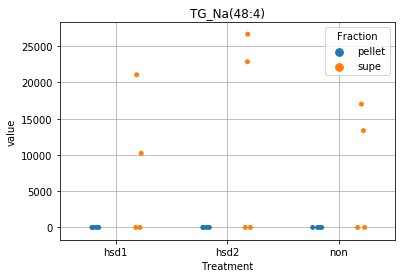

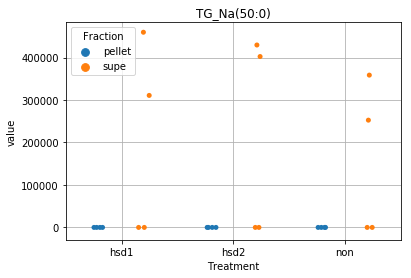

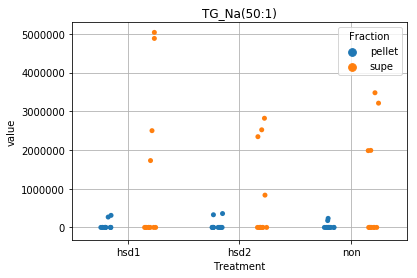

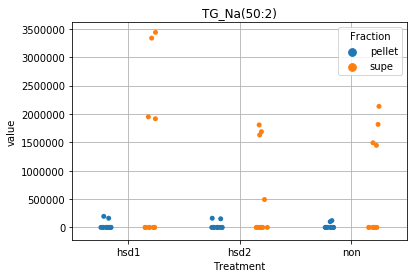

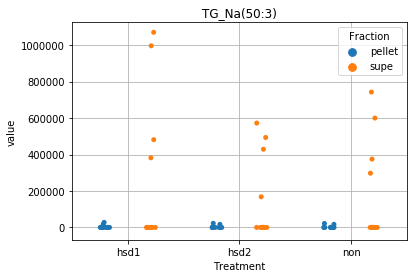

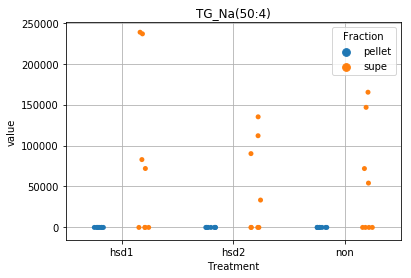

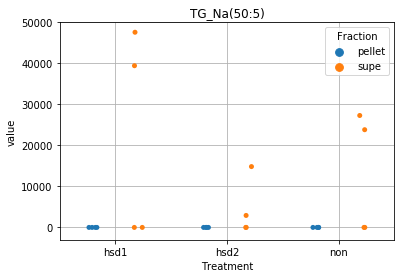

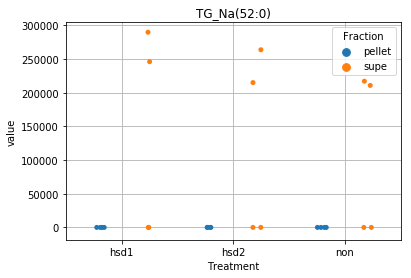

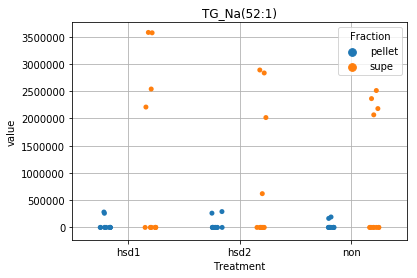

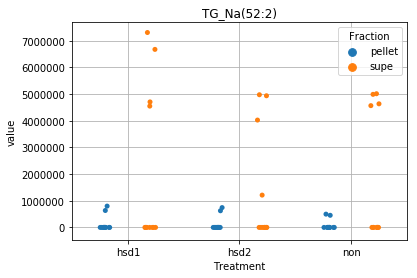

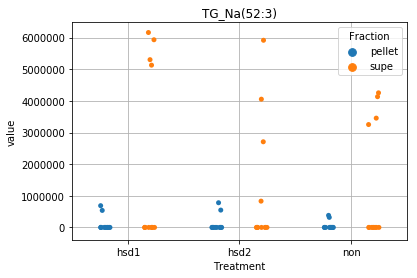

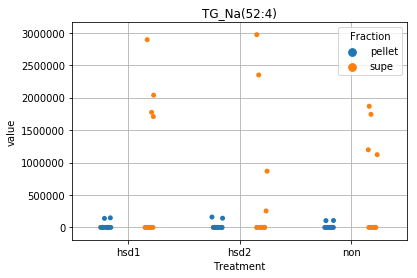

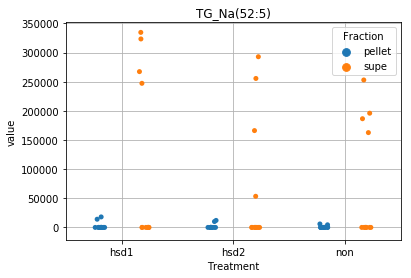

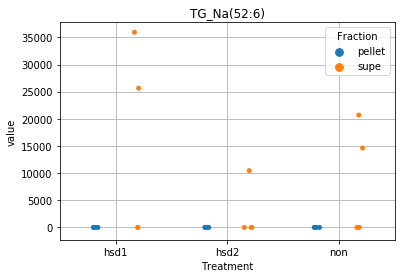

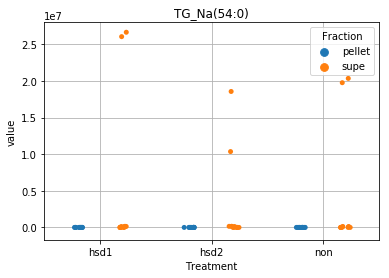

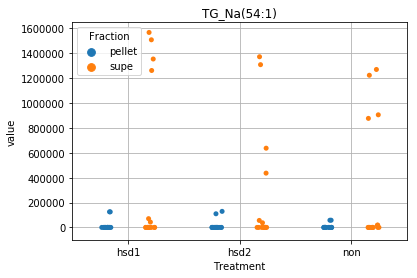

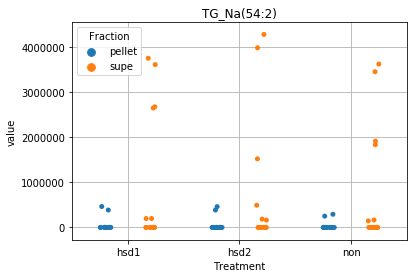

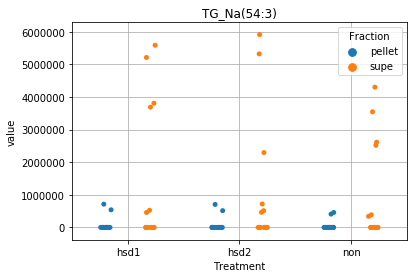

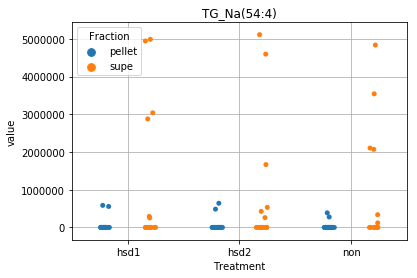

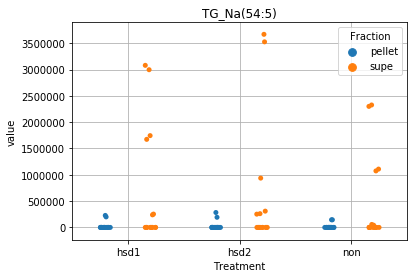

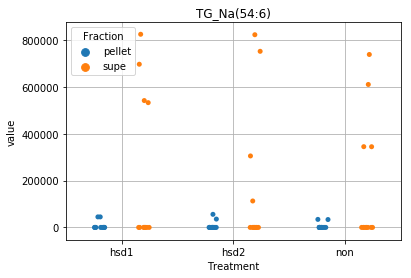

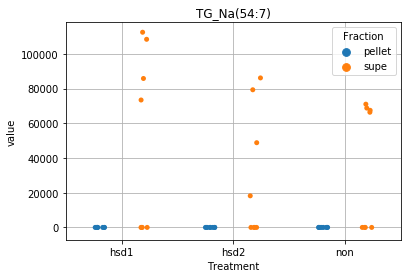

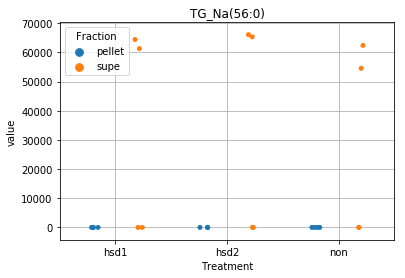

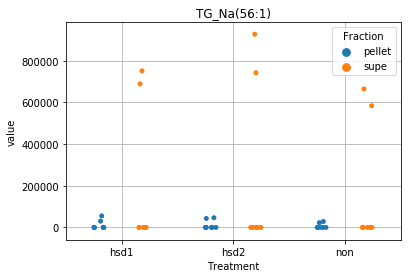

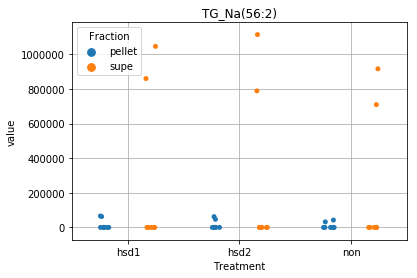

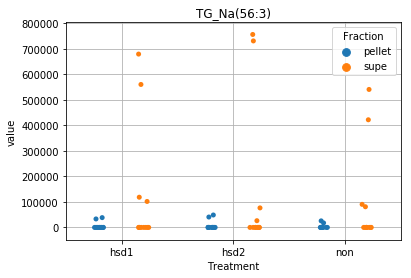

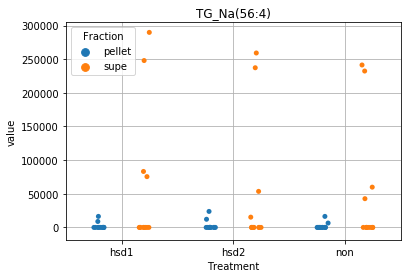

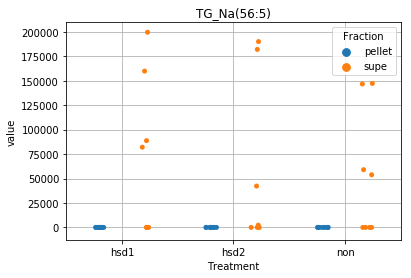

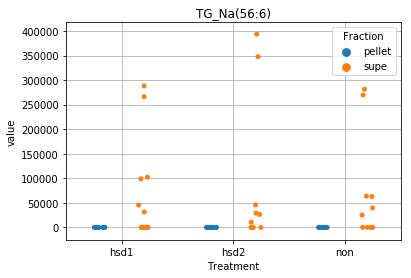

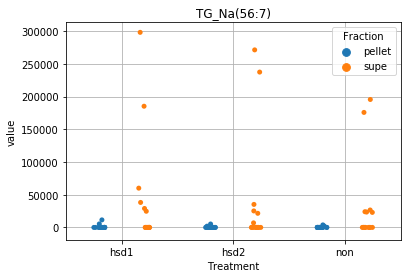

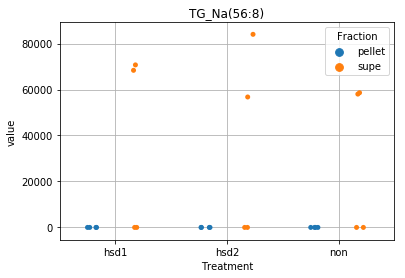

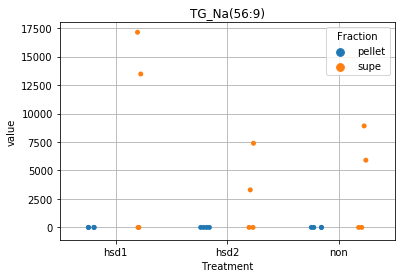

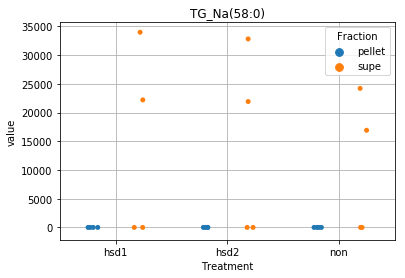

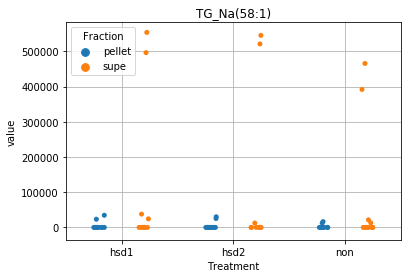

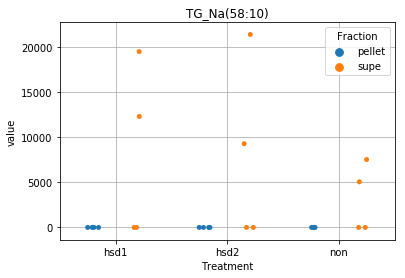

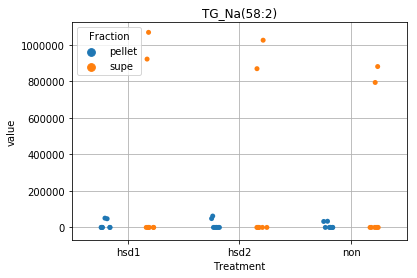

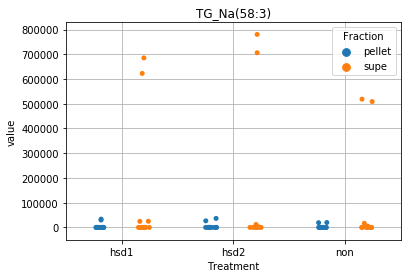

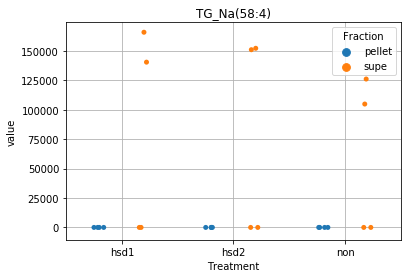

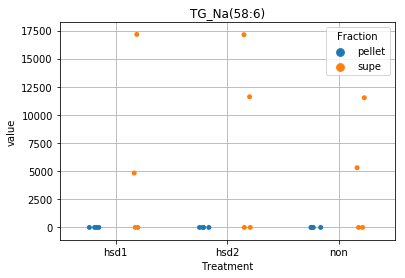

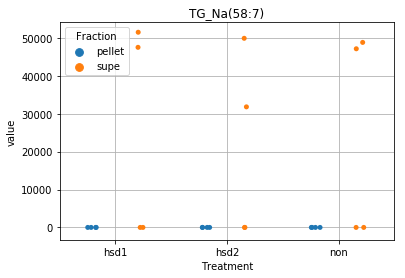

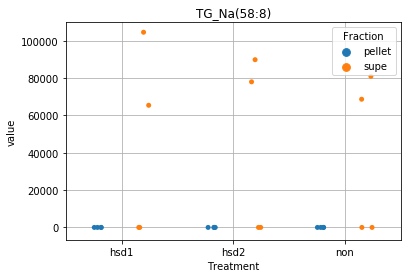

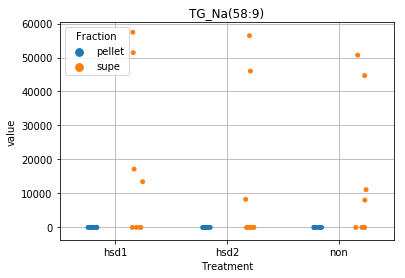

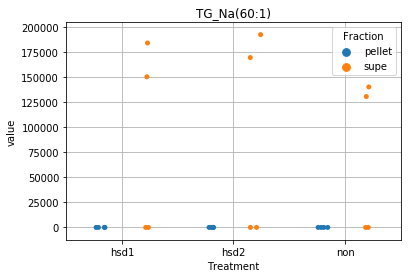

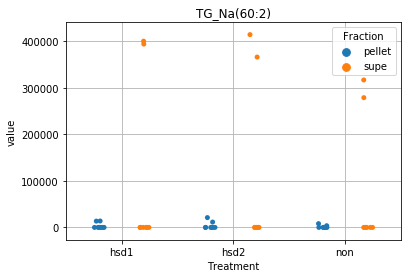

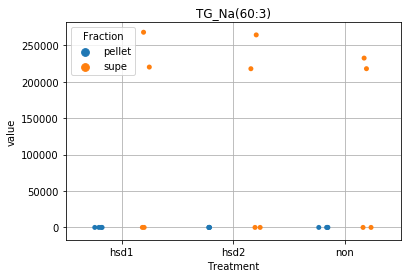

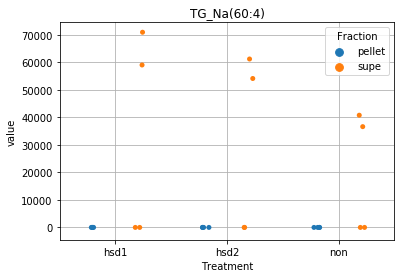

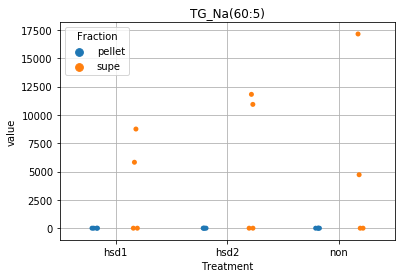

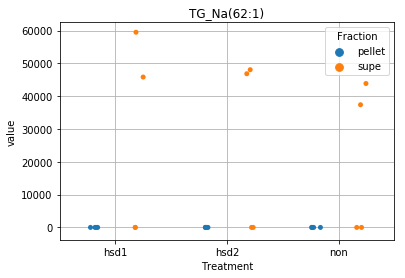

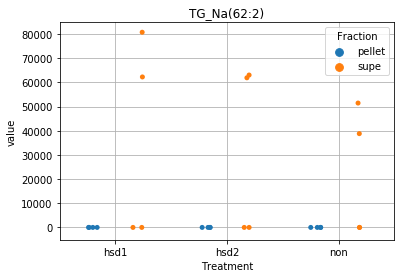

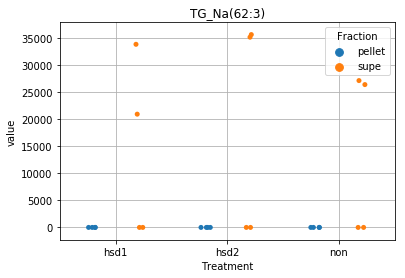

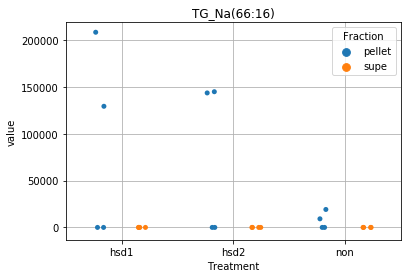

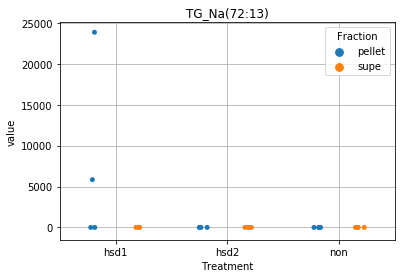

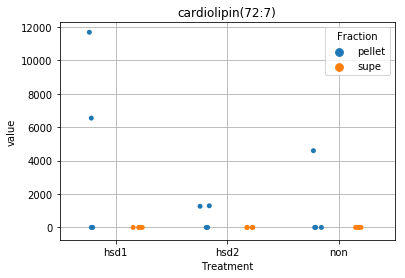

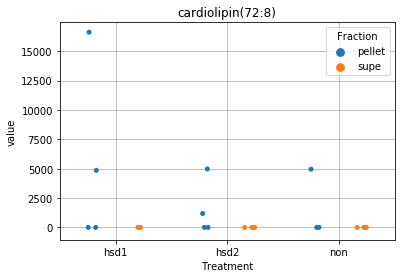

In [1355]:
data = df[[c for c in df.columns if '_' in c]+['compound']]
counter = 0
for lbl, grp in data.groupby(['compound']):
    d = grp[[c for c in grp.columns if '_' in c]].T.reset_index().copy()
    d['Fraction'] = d['index'].str.extract(r"(supe|pellet|blank)", expand = False)
    d['Mode'] = d['index'].str.extract(r"(pos|neg)", expand = False)
    d['Treatment'] = d['index'].str.extract(r"(activated|blank|hsd1|hsd2|non|buffer)", expand = False)
    
    d = d[d['Treatment'].isin(['non','hsd1','hsd2'])]
    
    q = d.melt(id_vars=['Fraction','Mode','Treatment'], value_vars = d.columns[1:-3]).fillna(0)
    plt.figure()
    plt.title(lbl)
    sns.stripplot(y = 'value', x = 'Treatment', hue = 'Fraction', data = q, dodge = True, jitter = True)
    plt.grid()

plt.show()


In [1428]:
data = df[[c for c in df.columns if '_' in c]+['compound']]
counter = 0
res = []
for lbl, grp in data.groupby(['compound']):
    d = grp[[c for c in grp.columns if '_' in c]].T.reset_index().copy()
    d['Fraction'] = d['index'].str.extract(r"(supe|pellet|blank)", expand = False)
    d['Mode'] = d['index'].str.extract(r"(pos|neg)", expand = False)
    d['Treatment'] = d['index'].str.extract(r"(activated|blank|hsd1|hsd2|non|buffer)", expand = False)
    
    d = d[d['Treatment'].isin(['non','hsd1','hsd2'])]
    d = d[d['Mode']=='pos']
    
    q = d.melt(id_vars=['Fraction','Mode','Treatment'], value_vars = d.columns[1:-3]).fillna(0)

    for frac,f in q.groupby('Fraction'):
        hsd1 = f[f.Treatment == 'hsd1']['value']
        non = f[f.Treatment == 'non']['value'] + 0.00001

        res.append({'hsd1 mean' : hsd1.mean(),
            'non mean' : non.mean(),
            'hsd1 values' : hsd1.values,
            'non values' : non.values,
            'Fold Change' : hsd1.mean() / non.mean(),
            'P Value': ttest_ind(hsd1, non, equal_var=False)[1],
            'Fraction': frac,
            'Compound': lbl})

res = pd.DataFrame(res)

In [1429]:
from scipy.stats import ttest_ind

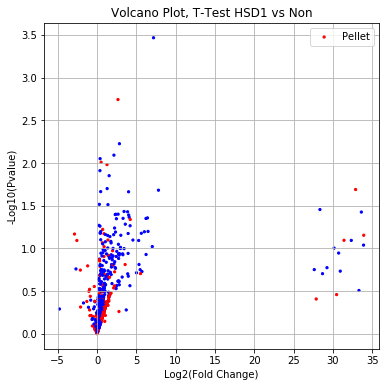

In [1430]:
plt.figure(figsize = (6,6))
plt.scatter(res['Fold Change'].apply(np.log2), -res['P Value'].apply(np.log10), s = 5, c = res['Fraction'].apply(lambda x: 'red' if x[0]=='p' else 'blue'))
plt.grid()
plt.xlabel('Log2(Fold Change)')
plt.ylabel('-Log10(Pvalue)')
plt.title('Volcano Plot, T-Test HSD1 vs Non')
plt.legend(['Pellet','Supernatant'])
plt.show()

In [1431]:
res.sort_values('Fold Change', ascending = False)

Compound   Fold Change Fraction   P Value  \
542                      PS(48:0)  1.625842e+10   pellet  0.070106   
549                      PS(54:4)  1.594472e+10     supe  0.091474   
219  Lactosyl Sphingosine (d18:1)  1.314267e+10     supe  0.037536   
385                      PE(32:1)  1.065939e+10     supe  0.310834   
544                      PS(48:1)  7.912799e+09   pellet  0.020435   
259                      PA(38:6)  5.411730e+09     supe  0.080568   
444                     PE(46:10)  2.851715e+09   pellet  0.080299   
571                SM(d18:1/20:1)  2.046539e+09     supe  0.184497   
231                  MG_NH4(22:3)  1.778749e+09     supe  0.113324   
934                  TG_Na(72:13)  1.485436e+09   pellet  0.347141   
589                SM(d18:1/24:4)  1.190736e+09     supe  0.099218   
181                     LPC(24:0)  6.359047e+08     supe  0.168123   
537                      PS(44:5)  4.292361e+08     supe  0.197623   
129                   DG_Na(34:3)  3.418930e+08     supe  0.035076   
546                      PS(48:2)  2.454079e+08   pellet  0.391002   
581                SM(d18:1/22:3)  2.072488e+08     supe  0.177077   
161                     LPA(18:2)  2.250680e+02     supe  0.020811   
221                  MG_NH4(18:3)  1.454083e+02     supe  0.000342   
241                   MG_Na(18:3)  1.303926e+02     supe  0.095145   
235                  MG_NH4(24:3)  8.982727e+01     supe  0.063260   
257                      PA(36:6)  8.526422e+01     supe  0.043946   
201                     LPG(20:1)  7.541773e+01     supe  0.117843   
199                     LPG(20:0)  7.488338e+01     supe  0.044598   
225                  MG_NH4(20:3)  6.481099e+01     supe  0.063857   
527                      PS(40:7)  5.251582e+01     supe  0.186547   
247                   MG_Na(22:1)  4.952802e+01     supe  0.066510   
706                 TG_NH4(56:10)  4.620026e+01   pellet  0.197256   
473                    PE(O-40:6)  4.472545e+01     supe  0.177493   
245                   MG_Na(20:5)  4.051764e+01     supe  0.154256   
191                     LPE(22:4)  3.923577e+01     supe  0.080743   
..                            ...           ...      ...       ...   
469                    PE(O-38:6)  0.000000e+00     supe  0.000000   
486                      PI(38:5)  0.000000e+00   pellet  0.000000   
484                      PI(38:4)  0.000000e+00   pellet  0.000000   
483                      PI(36:4)  0.000000e+00     supe  0.000000   
482                      PI(36:4)  0.000000e+00   pellet  0.000000   
481                      PI(36:3)  0.000000e+00     supe  0.000000   
480                      PI(36:3)  0.000000e+00   pellet  0.000000   
479                      PI(34:1)  0.000000e+00     supe  0.000000   
478                      PI(34:1)  0.000000e+00   pellet  0.000000   
477                     PG(46:12)  0.000000e+00     supe  0.000000   
476                     PG(46:12)  0.000000e+00   pellet  0.000000   
475                    PE(O-42:5)  0.000000e+00     supe  0.000000   
471                    PE(O-40:5)  0.000000e+00     supe  0.000000   
1                           C16:0  0.000000e+00     supe  0.000000   
465                    PE(O-38:4)  0.000000e+00     supe  0.000000   
431                      PE(40:8)  0.000000e+00     supe  0.000000   
461                    PE(O-36:3)  0.000000e+00     supe  0.000000   
459                    PE(O-36:2)  0.000000e+00     supe  0.000000   
457                     PE(58:11)  0.000000e+00     supe  0.000000   
453                      PE(56:5)  0.000000e+00     supe  0.000000   
449                      PE(52:4)  0.000000e+00     supe  0.000000   
447                      PE(46:9)  0.000000e+00     supe  0.000000   
445                     PE(46:10)  0.000000e+00     supe  0.000000   
443                      PE(42:8)  0.000000e+00     supe  0.000000   
441                      PE(42:7)  0.000000e+00     supe  0.000000   
439                      PE(42:6)  